## Prism Data

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
consdf = pd.read_parquet('/uss/hdsi-prismdata/q2-ucsd-consDF.pqt') #shows delinquents and credit score
acctdf = pd.read_parquet('/uss/hdsi-prismdata/q2-ucsd-acctDF.pqt') #displays accounts and balances
trxndf = pd.read_parquet('/uss/hdsi-prismdata/q2-ucsd-trxnDF.pqt') #each transaction with category number and amounts
cat_map = pd.read_csv('/uss/hdsi-prismdata/q2-ucsd-cat-map.csv') #mapping for category numbers

In [3]:
cat_map

,category_id,category
0,0,SELF_TRANSFER
1,1,EXTERNAL_TRANSFER
2,2,DEPOSIT
3,3,PAYCHECK
4,4,MISCELLANEOUS
5,5,PAYCHECK_PLACEHOLDER
6,6,REFUND
7,7,INVESTMENT_INCOME
8,8,OTHER_BENEFITS
9,9,UNEMPLOYMENT_BENEFITS


In [4]:
consdf.dropna()['prism_consumer_id'].nunique(),acctdf['prism_consumer_id'].nunique(),trxndf['prism_consumer_id'].nunique()

(12000, 13009, 14492)

In [5]:
total = set(consdf.dropna()['prism_consumer_id'].unique()) & set(acctdf['prism_consumer_id'].unique()) & set(trxndf['prism_consumer_id'].unique())
len(total)

10122

### Week 3

In [6]:
initial_df = (
    acctdf
    .merge(consdf, on='prism_consumer_id', how='inner')
    .groupby(['prism_consumer_id'])
    .agg(
        balance=('balance', 'sum'),
        balance_date=('balance_date', 'max')
    )
    .reset_index()
).merge(trxndf,on='prism_consumer_id')
initial_df

,prism_consumer_id,balance,balance_date,prism_transaction_id,category,amount,credit_or_debit,posted_date
0,0,320.37,2021-08-31,136696,4,0.09,CREDIT,2021-03-19
1,0,320.37,2021-08-31,136697,4,0.05,CREDIT,2021-04-16
2,0,320.37,2021-08-31,136698,4,0.06,CREDIT,2021-05-21
3,0,320.37,2021-08-31,136699,4,0.04,CREDIT,2021-06-18
4,0,320.37,2021-08-31,136700,4,0.02,CREDIT,2021-07-16
...,...,...,...,...,...,...,...,...
5202934,9999,-9.02,2023-08-09,1522635,16,66.63,DEBIT,2023-08-08
5202935,9999,-9.02,2023-08-09,1522636,14,16.91,DEBIT,2023-08-08
5202936,9999,-9.02,2023-08-09,1522637,14,3.52,DEBIT,2023-08-08
5202937,9999,-9.02,2023-08-09,1522638,16,7.99,DEBIT,2023-08-08


In [7]:
mapping = dict(zip(cat_map["category_id"], cat_map["category"]))
initial_df["category"] = initial_df["category"].replace(mapping)
monthly_summary=initial_df.copy()
monthly_summary['amount'] = np.where(initial_df['credit_or_debit'] == 'DEBIT', -initial_df['amount'],initial_df['amount'])
monthly_summary['posted_date'] = pd.to_datetime(monthly_summary['posted_date'])
monthly_summary = (
    monthly_summary
    .groupby(['prism_consumer_id', monthly_summary['posted_date'].dt.to_period('M')])
    .agg(
        starting_balance=('balance', 'first'),
        monthly_total=('balance', 'sum'),
        trxndf_count = ('balance', 'count')
    )
    .reset_index()
)
monthly_summary['posted_date'] = monthly_summary['posted_date'].dt.to_timestamp()

In [8]:
monthly_summary = monthly_summary.merge(consdf[['prism_consumer_id','DQ_TARGET']],on='prism_consumer_id').dropna()

In [9]:
# ensure date type
monthly_summary["posted_date"] = pd.to_datetime(monthly_summary["posted_date"])

# sort properly
monthly_summary = monthly_summary.sort_values(["prism_consumer_id", "posted_date"])

# calculate running balance
monthly_summary["monthly_balance"] = (
    monthly_summary["starting_balance"]
    + monthly_summary.groupby("prism_consumer_id")["monthly_total"].cumsum()
)
monthly_summary

,prism_consumer_id,posted_date,starting_balance,monthly_total,trxndf_count,DQ_TARGET,monthly_balance
0,0,2021-03-01,320.37,10572.21,33,0.0,10892.58
1,0,2021-04-01,320.37,22105.53,69,0.0,32998.11
2,0,2021-05-01,320.37,11853.69,37,0.0,44851.80
3,0,2021-06-01,320.37,27231.45,85,0.0,72083.25
4,0,2021-07-01,320.37,23707.38,74,0.0,95790.63
...,...,...,...,...,...,...,...
74439,999,2020-11-01,2236.37,140891.31,63,0.0,237055.22
74440,999,2020-12-01,2236.37,351110.09,157,0.0,588165.31
74441,999,2021-01-01,2236.37,272837.14,122,0.0,861002.45
74442,999,2021-02-01,2236.37,339928.24,152,0.0,1200930.69


In [10]:
del_df = monthly_summary[monthly_summary['DQ_TARGET'] == 1]
nondel_df = monthly_summary[monthly_summary['DQ_TARGET'] == 0]
ids_1 = del_df["prism_consumer_id"].dropna().unique()
ids_0 = del_df["prism_consumer_id"].dropna().unique()

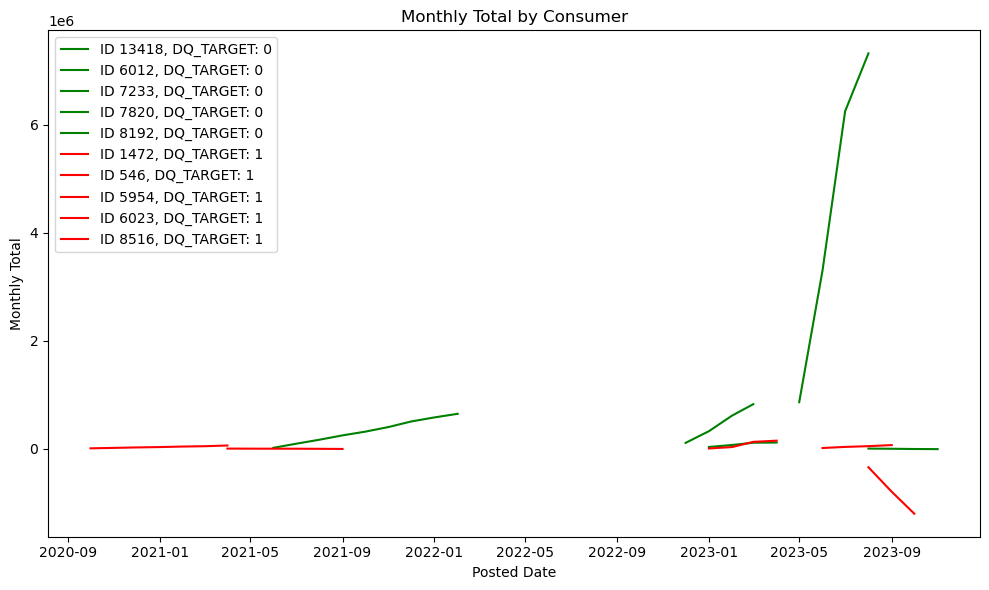

In [11]:
random.seed(10)

n=5

ids = np.random.choice(ids_0, size=n, replace=False)
ids2 = np.random.choice(ids_1,size=n,replace=False)

subset = monthly_summary[monthly_summary['prism_consumer_id'].isin(ids)]
subset2 = monthly_summary[monthly_summary['prism_consumer_id'].isin(ids2)]

plt.figure(figsize=(10, 6))

for pid, df in subset.groupby('prism_consumer_id'):
    plt.plot(df['posted_date'], df['monthly_balance'], label=f'ID {pid}, DQ_TARGET: 0',color='green')
    
for pid, df in subset2.groupby('prism_consumer_id'):
    plt.plot(df['posted_date'], df['monthly_balance'], label=f'ID {pid}, DQ_TARGET: 1',color='red')

plt.xlabel('Posted Date')
plt.ylabel('Monthly Total')
plt.title('Monthly Total by Consumer')
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
monthly_summary

,prism_consumer_id,posted_date,starting_balance,monthly_total,trxndf_count,DQ_TARGET,monthly_balance
0,0,2021-03-01,320.37,10572.21,33,0.0,10892.58
1,0,2021-04-01,320.37,22105.53,69,0.0,32998.11
2,0,2021-05-01,320.37,11853.69,37,0.0,44851.80
3,0,2021-06-01,320.37,27231.45,85,0.0,72083.25
4,0,2021-07-01,320.37,23707.38,74,0.0,95790.63
...,...,...,...,...,...,...,...
74439,999,2020-11-01,2236.37,140891.31,63,0.0,237055.22
74440,999,2020-12-01,2236.37,351110.09,157,0.0,588165.31
74441,999,2021-01-01,2236.37,272837.14,122,0.0,861002.45
74442,999,2021-02-01,2236.37,339928.24,152,0.0,1200930.69


### mtotal_df

In [13]:
mtotal_df = monthly_summary.groupby('prism_consumer_id').agg(
        DQ_TARGET = ('DQ_TARGET', 'first'),
        monthly_mean=('monthly_total', 'mean'),
        monthly_max=('monthly_total', 'max'),
        monthly_min=('monthly_total', 'min'),
        trxndf_count = ('trxndf_count','first'),
        month_count=('monthly_total', 'count')
    )
mtotal_df

,DQ_TARGET,monthly_mean,monthly_max,monthly_min,trxndf_count,month_count
prism_consumer_id,,,,,,
0,0.0,1.867299e+04,27231.45,8970.36,33,7
1,0.0,1.481371e+05,208052.46,102375.02,31,7
10,0.0,4.015226e+04,60169.52,19781.76,31,7
100,0.0,5.399456e+04,63731.28,45142.99,19,6
1000,0.0,2.871107e+03,3524.25,476.25,5,7
...,...,...,...,...,...,...
995,0.0,2.053630e+06,3162590.31,670852.49,17,7
996,0.0,0.000000e+00,0.00,0.00,32,7
997,0.0,4.787867e+06,6756531.35,1404823.35,21,7


In [14]:
from sklearn.model_selection import train_test_split

X = mtotal_df.drop(columns='DQ_TARGET')
y = mtotal_df['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
])

pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [15]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


ROC AUC: 0.6773498120150389
              precision    recall  f1-score   support

         0.0       0.97      0.61      0.75      2315
         1.0       0.16      0.77      0.26       216

    accuracy                           0.63      2531
   macro avg       0.56      0.69      0.50      2531
weighted avg       0.90      0.63      0.71      2531



In [16]:
cd_df = initial_df[['prism_consumer_id','amount','credit_or_debit']].groupby(['prism_consumer_id','credit_or_debit']).sum().reset_index()
cd_df

,prism_consumer_id,credit_or_debit,amount
0,0,CREDIT,14386.82
1,0,DEBIT,14908.41
2,1,CREDIT,24903.80
3,1,DEBIT,23098.37
4,10,CREDIT,20576.56
...,...,...,...
25008,9997,DEBIT,16702.92
25009,9998,CREDIT,14566.37
25010,9998,DEBIT,15399.47
25011,9999,CREDIT,31777.82


### cd_df

In [17]:
cd_df = (
    cd_df
    .pivot_table(
        index='prism_consumer_id',
        columns='credit_or_debit',
        values='amount',
        aggfunc='sum',
        fill_value=0
    )
    .assign(
        credit_debit_ratio=lambda x: x['CREDIT'] / (x['DEBIT'] + 1),
        net_flow=lambda x: x['CREDIT'] - x['DEBIT']
    )
)

In [18]:
cd_df = cd_df.reset_index().merge(consdf[['prism_consumer_id','DQ_TARGET']],on='prism_consumer_id').dropna()
cd_df

,prism_consumer_id,CREDIT,DEBIT,credit_debit_ratio,net_flow,DQ_TARGET
0,0,14386.82,14908.41,0.964949,-521.59,0.0
1,1,24903.80,23098.37,1.078116,1805.43,0.0
2,10,20576.56,21766.60,0.945284,-1190.04,0.0
3,100,35236.84,39742.61,0.886604,-4505.77,0.0
4,1000,78353.07,77914.99,1.005610,438.08,0.0
...,...,...,...,...,...,...
12598,995,53309.15,31466.47,1.694103,21842.68,0.0
12607,996,222962.79,196249.61,1.136113,26713.18,0.0
12616,997,66176.94,81076.60,0.816217,-14899.66,0.0
12626,998,71714.74,66207.01,1.083173,5507.73,0.0


In [19]:
from sklearn.model_selection import train_test_split

X = cd_df.drop(columns = ['prism_consumer_id','DQ_TARGET'])
y = cd_df['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [20]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


ROC AUC: 0.6278297736181105
              precision    recall  f1-score   support

         0.0       0.95      0.38      0.54      2315
         1.0       0.11      0.80      0.19       216

    accuracy                           0.41      2531
   macro avg       0.53      0.59      0.36      2531
weighted avg       0.88      0.41      0.51      2531



In [21]:
net_df = initial_df[['prism_consumer_id','posted_date','category','credit_or_debit','amount']].copy()
net_df['amount'] = np.where(net_df['credit_or_debit'] == 'DEBIT', -net_df['amount'],net_df['amount'])
net_df['posted_date'] = pd.to_datetime(net_df['posted_date'])
net_df['month'] = net_df['posted_date'].dt.to_period('M')
mn_df = net_df.groupby(['prism_consumer_id','month']).agg(
        monthly_total=('amount', 'sum'),
        monthly_std =('amount','std')
    ).reset_index()
mn_df

,prism_consumer_id,month,monthly_total,monthly_std
0,0,2021-03,401.34,332.210452
1,0,2021-04,830.73,238.858943
2,0,2021-05,201.50,163.856341
3,0,2021-06,-2584.24,102.201363
4,0,2021-07,-71.38,187.201528
...,...,...,...,...
74473,9998,2023-10,15.86,252.389925
74474,9999,2023-05,3175.69,480.769524
74475,9999,2023-06,-236.42,428.377690
74476,9999,2023-07,-1288.34,428.713815


### monthly_features

In [22]:
monthly_features = mn_df.groupby(['prism_consumer_id']).agg(
    monthly_net_total=('monthly_total', 'sum'),
    monthly_net_avg=('monthly_total', 'mean'),
    monthly_net_max=('monthly_total', 'max'),
    monthly_net_min=('monthly_total', 'min'),
    monthly_std_avg=('monthly_std', 'mean')
).reset_index().merge(consdf[['prism_consumer_id','DQ_TARGET']],on='prism_consumer_id').dropna()
monthly_features['prism_consumer_id'] = monthly_features['prism_consumer_id'].astype(int)
mtotal_df = mtotal_df.reset_index()
mtotal_df['prism_consumer_id'] = mtotal_df['prism_consumer_id'].astype(int)
cd_df['prism_consumer_id'] = cd_df['prism_consumer_id'].astype(int)
monthly_features['net_range'] = monthly_features['monthly_net_max'] - monthly_features['monthly_net_min']
monthly_features

,prism_consumer_id,monthly_net_total,monthly_net_avg,monthly_net_max,monthly_net_min,monthly_std_avg,DQ_TARGET,net_range
0,0,-521.59,-74.512857,830.73,-2584.24,213.544425,0.0,3414.97
1,1,1805.43,257.918571,1109.02,-940.73,292.763392,0.0,2049.75
2,10,-1190.04,-170.005714,431.40,-971.45,260.603079,0.0,1402.85
3,100,-4505.77,-750.961667,1276.72,-3332.81,832.186871,0.0,4609.53
4,1000,438.08,62.582857,2982.67,-2884.56,1223.790895,0.0,5867.23
...,...,...,...,...,...,...,...,...
12598,995,21842.68,3120.382857,10212.74,-3244.20,1016.422674,0.0,13456.94
12607,996,26713.18,3816.168571,41464.50,-16811.41,2623.765971,0.0,58275.91
12616,997,-14899.66,-2128.522857,206.99,-3741.45,745.079512,0.0,3948.44
12626,998,5507.73,786.818571,3359.83,-1022.35,537.836676,0.0,4382.18


In [23]:
from sklearn.model_selection import train_test_split

X = monthly_features.drop(columns=['prism_consumer_id','DQ_TARGET'])
y = monthly_features['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
])

pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [24]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


ROC AUC: 0.6050277339575594
              precision    recall  f1-score   support

         0.0       0.96      0.36      0.53      2285
         1.0       0.11      0.82      0.19       215

    accuracy                           0.40      2500
   macro avg       0.53      0.59      0.36      2500
weighted avg       0.88      0.40      0.50      2500



In [25]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_prob))


ROC AUC: 0.6840506844435398


In [26]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc'
)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [27]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

ROC AUC: 0.6895353926008855
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      2285
         1.0       0.56      0.02      0.04       215

    accuracy                           0.91      2500
   macro avg       0.74      0.51      0.50      2500
weighted avg       0.88      0.91      0.88      2500



In [28]:
import pandas as pd

importance = pd.Series(
    xgb.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importance.head(10)

monthly_net_total    0.191621
monthly_net_max      0.188124
net_range            0.170834
monthly_std_avg      0.152746
monthly_net_avg      0.149985
monthly_net_min      0.146690
dtype: float32

### catsum_df

In [29]:
initial_df['amount'] = np.where(initial_df['credit_or_debit'] == 'DEBIT', -initial_df['amount'],initial_df['amount'])
cat_df = initial_df.groupby(['prism_consumer_id','category'])['amount'].sum().reset_index()

In [30]:
cat_pivot = (
    cat_df
    .pivot(
        index='prism_consumer_id',
        columns='category',
        values='amount'
    )
    .fillna(0)
)
cat_pivot

category,ACCOUNT_FEES,ATM_CASH,AUTOMOTIVE,AUTO_LOAN,BANKING_CATCH_ALL,BILLS_UTILITIES,BNPL,CHILD_DEPENDENTS,CORPORATE_PAYMENTS,CREDIT_CARD_PAYMENT,...,REFUND,RENT,RISK_CATCH_ALL,RTO_LTO,SELF_TRANSFER,TAX,TIME_OR_STUFF,TRANSPORATION,TRAVEL,UNEMPLOYMENT_BENEFITS
prism_consumer_id,,,,,,,,,,,,,,,,,,,,,
0,0.00,-540.00,-527.15,0.00,-1980.00,0.00,0.00,0.0,0.0,0.00,...,19.96,0.0,0.0,0.0,1.741030e+03,2603.52,0.0,-2.48,-108.75,0.0
1,0.00,-6999.13,-195.18,0.00,0.00,0.00,-251.43,0.0,0.0,0.00,...,2.42,0.0,0.0,0.0,0.000000e+00,2325.40,0.0,-51.80,0.00,0.0
10,0.00,-4112.00,-483.06,0.00,0.00,0.00,0.00,0.0,0.0,-180.00,...,92.33,-103.0,0.0,0.0,-5.684342e-14,0.00,0.0,-35.04,0.00,0.0
100,0.00,-200.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,-16188.17,...,11.75,0.0,0.0,0.0,-4.202680e+03,0.00,0.0,0.00,0.00,0.0
1000,0.00,0.00,-204.03,0.00,0.00,0.00,0.00,0.0,0.0,-14756.05,...,1.37,0.0,0.0,0.0,-3.162727e+04,0.00,0.0,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.00,-1260.18,-115.56,-672.78,0.00,-53.98,-167.60,0.0,0.0,-512.48,...,0.00,0.0,0.0,0.0,0.000000e+00,0.00,0.0,0.00,0.00,0.0
9996,0.00,0.00,-75.39,0.00,-184.34,0.00,0.00,0.0,0.0,0.00,...,0.00,0.0,0.0,0.0,0.000000e+00,0.00,0.0,0.00,-27.69,0.0
9997,-10.50,-1053.25,-217.60,-962.16,0.00,-230.00,-729.08,0.0,0.0,-829.00,...,335.00,0.0,0.0,0.0,0.000000e+00,0.00,0.0,0.00,-136.34,0.0


In [31]:
outflows = cat_pivot.clip(upper=0).abs()
inflows  = cat_pivot.clip(lower=0)

cat_features = pd.DataFrame(index=cat_pivot.index)

cat_features['total_outflows'] = outflows.sum(axis=1)
cat_features['total_inflows']  = inflows.sum(axis=1)
cat_features['net_flow']       = cat_pivot.sum(axis=1)


In [32]:
for col in outflows.columns:
    cat_features[f'{col}_outflow_ratio'] = (
        outflows[col] / (cat_features['total_outflows'] + 1)
    )


In [33]:
# Income reliance
cat_features['paycheck_ratio'] = (
    inflows.get('PAYCHECK', 0) / (cat_features['total_inflows'] + 1)
)

# Cash usage
cat_features['atm_cash_ratio'] = (
    outflows.get('ATM_CASH', 0) / (cat_features['total_outflows'] + 1)
)

# Entertainment vs essentials proxy
cat_features['entertainment_ratio'] = (
    outflows.get('ENTERTAINMENT', 0) / (cat_features['total_outflows'] + 1)
)

# Refund dependence
cat_features['refund_ratio'] = (
    inflows.get('REFUND', 0) / (cat_features['total_inflows'] + 1)
)

In [34]:
outflows = outflows.reset_index().merge(consdf[['prism_consumer_id','DQ_TARGET']],on='prism_consumer_id').dropna()
outflows

,prism_consumer_id,ACCOUNT_FEES,ATM_CASH,AUTOMOTIVE,AUTO_LOAN,BANKING_CATCH_ALL,BILLS_UTILITIES,BNPL,CHILD_DEPENDENTS,CORPORATE_PAYMENTS,...,RENT,RISK_CATCH_ALL,RTO_LTO,SELF_TRANSFER,TAX,TIME_OR_STUFF,TRANSPORATION,TRAVEL,UNEMPLOYMENT_BENEFITS,DQ_TARGET
0,0,0.0,540.00,527.15,0.0,1980.00,0.00,0.00,0.0,0.0,...,0.00,0.0,0.0,0.000000e+00,0.0,0.0,2.48,108.75,0.0,0.0
1,1,0.0,6999.13,195.18,0.0,0.00,0.00,251.43,0.0,0.0,...,0.00,0.0,0.0,0.000000e+00,0.0,0.0,51.80,0.00,0.0,0.0
2,10,0.0,4112.00,483.06,0.0,0.00,0.00,0.00,0.0,0.0,...,103.00,0.0,0.0,5.684342e-14,0.0,0.0,35.04,0.00,0.0,0.0
3,100,0.0,200.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,...,0.00,0.0,0.0,4.202680e+03,0.0,0.0,0.00,0.00,0.0,0.0
4,1000,0.0,0.00,204.03,0.0,0.00,0.00,0.00,0.0,0.0,...,0.00,0.0,0.0,3.162727e+04,0.0,0.0,0.00,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12598,995,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,...,5670.79,0.0,0.0,0.000000e+00,0.0,0.0,0.00,0.00,0.0,0.0
12607,996,0.0,11500.00,1090.58,0.0,67.79,0.00,0.00,0.0,0.0,...,0.00,0.0,0.0,0.000000e+00,0.0,0.0,12.00,5433.00,0.0,0.0
12616,997,0.0,11640.00,0.00,0.0,300.00,0.00,0.00,0.0,0.0,...,0.00,0.0,0.0,4.048990e+03,0.0,0.0,0.00,0.00,0.0,0.0
12626,998,0.0,1130.57,1958.32,0.0,3441.84,881.68,568.81,209.4,0.0,...,693.95,0.0,0.0,0.000000e+00,0.0,0.0,63.50,496.28,0.0,0.0


In [35]:
cat_features = cat_features.reset_index().merge(consdf[['prism_consumer_id','DQ_TARGET']],on='prism_consumer_id').dropna()

In [36]:
from sklearn.model_selection import train_test_split

X = outflows.drop(columns=['prism_consumer_id','DQ_TARGET'])
y = outflows['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
])

pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [37]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


ROC AUC: 0.6716342692584594
              precision    recall  f1-score   support

         0.0       0.95      0.53      0.68      2315
         1.0       0.13      0.73      0.21       216

    accuracy                           0.54      2531
   macro avg       0.54      0.63      0.45      2531
weighted avg       0.88      0.54      0.64      2531



In [38]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_prob))


ROC AUC: 0.7397808175345972


In [39]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc'
)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [40]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

ROC AUC: 0.7454403647708183
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      2315
         1.0       0.56      0.04      0.08       216

    accuracy                           0.92      2531
   macro avg       0.74      0.52      0.52      2531
weighted avg       0.89      0.92      0.88      2531



In [41]:
import pandas as pd

importance = pd.Series(
    xgb.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importance.head(5)

OVERDRAFT              0.040062
ACCOUNT_FEES           0.038719
CREDIT_CARD_PAYMENT    0.031763
RTO_LTO                0.031227
INSURANCE              0.031061
dtype: float32

In [42]:
categories_with_weight = importance[importance > 0].index.tolist()
categories_with_weight = categories_with_weight + ['prism_consumer_id']

In [43]:
add_df = cat_features[['prism_consumer_id','refund_ratio','paycheck_ratio']].copy()
add_df['prism_consumer_id'] = add_df['prism_consumer_id'].astype(int)
outflows['prism_consumer_id'] = outflows['prism_consumer_id'].astype(int)
out_df = outflows[categories_with_weight].copy()
out_df

,OVERDRAFT,ACCOUNT_FEES,CREDIT_CARD_PAYMENT,RTO_LTO,INSURANCE,AUTOMOTIVE,BNPL,INVESTMENT,GROCERIES,ENTERTAINMENT,...,RENT,GOVERNMENT_SERVICES,TAX,TRANSPORATION,FITNESS,BANKING_CATCH_ALL,LEGAL,GIFTS_DONATIONS,RISK_CATCH_ALL,prism_consumer_id
0,0.0,0.0,0.00,0.0,0.00,527.15,0.00,0.0,997.63,151.71,...,0.00,0.0,0.0,2.48,150.60,1980.00,0.0,0.0,0.0,0
1,0.0,0.0,0.00,0.0,0.00,195.18,251.43,0.0,427.27,275.25,...,0.00,0.0,0.0,51.80,0.00,0.00,0.0,0.0,0.0,1
2,0.0,0.0,180.00,0.0,0.00,483.06,0.00,0.0,621.79,107.64,...,103.00,0.0,0.0,35.04,0.00,0.00,0.0,50.0,0.0,10
3,0.0,0.0,16188.17,0.0,1942.76,0.00,0.00,0.0,403.50,0.00,...,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,100
4,0.0,0.0,14756.05,0.0,0.00,204.03,0.00,0.0,0.00,0.00,...,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12598,0.0,0.0,14832.19,0.0,355.27,0.00,0.00,0.0,472.66,0.00,...,5670.79,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,995
12607,0.0,0.0,17665.91,0.0,0.00,1090.58,0.00,3000.0,1074.43,1330.34,...,0.00,1807.4,0.0,12.00,0.00,67.79,0.0,0.0,0.0,996
12616,0.0,0.0,6121.09,0.0,0.00,0.00,0.00,0.0,0.00,0.00,...,0.00,0.0,0.0,0.00,0.00,300.00,0.0,0.0,0.0,997
12626,0.0,0.0,300.00,0.0,1047.42,1958.32,568.81,0.0,4907.57,625.97,...,693.95,40.0,0.0,63.50,75.49,3441.84,0.0,0.0,0.0,998


### catavg_df

In [44]:
initial_df['amount'] = np.where(initial_df['credit_or_debit'] == 'DEBIT', -initial_df['amount'],initial_df['amount'])
cat_df = initial_df.groupby(['prism_consumer_id','category'])['amount'].mean().reset_index()
cat_df

,prism_consumer_id,category,amount
0,0,ATM_CASH,180.000000
1,0,AUTOMOTIVE,25.102381
2,0,BANKING_CATCH_ALL,396.000000
3,0,DEPOSIT,500.000000
4,0,ENTERTAINMENT,25.285000
...,...,...,...
239827,9999,MISCELLANEOUS,77.280526
239828,9999,PAYCHECK,2563.146667
239829,9999,REFUND,23.760000
239830,9999,TRANSPORATION,9.480714


In [45]:
cat_pivot = (
    cat_df
    .pivot(
        index='prism_consumer_id',
        columns='category',
        values='amount'
    )
    .fillna(0)
)
cat_pivot.columns = cat_pivot.columns + "_trxnavg"
cat_pivot = cat_pivot.reset_index().merge(consdf[['prism_consumer_id','DQ_TARGET']],on='prism_consumer_id').dropna()
cat_pivot['prism_consumer_id'] = cat_pivot['prism_consumer_id'].astype(int)
cat_pivot

,prism_consumer_id,ACCOUNT_FEES_trxnavg,ATM_CASH_trxnavg,AUTOMOTIVE_trxnavg,AUTO_LOAN_trxnavg,BANKING_CATCH_ALL_trxnavg,BILLS_UTILITIES_trxnavg,BNPL_trxnavg,CHILD_DEPENDENTS_trxnavg,CORPORATE_PAYMENTS_trxnavg,...,RENT_trxnavg,RISK_CATCH_ALL_trxnavg,RTO_LTO_trxnavg,SELF_TRANSFER_trxnavg,TAX_trxnavg,TIME_OR_STUFF_trxnavg,TRANSPORATION_trxnavg,TRAVEL_trxnavg,UNEMPLOYMENT_BENEFITS_trxnavg,DQ_TARGET
0,0,0.0,180.000000,25.102381,0.0,396.00,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,116.685652,867.840,0.000000,2.480000,54.375000,0.0,0.0
1,1,0.0,199.975143,27.882857,0.0,0.00,0.000000,17.959286,0.0,0.0,...,0.000000,0.0,0.0,233.410256,1162.700,0.000000,25.900000,0.000000,0.0,0.0
2,10,0.0,228.444444,21.002609,0.0,0.00,0.000000,0.000000,0.0,0.0,...,103.000000,0.0,0.0,237.568750,0.000,0.000000,17.520000,0.000000,0.0,0.0
3,100,0.0,200.000000,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,547.296667,0.000,0.000000,0.000000,0.000000,0.0,0.0
4,1000,0.0,0.000000,34.005000,0.0,0.00,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,828.920370,0.000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12598,995,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.0,...,1134.158000,0.0,0.0,1250.937000,626.432,0.000000,0.000000,0.000000,0.0,0.0
12607,996,0.0,1437.500000,35.180000,0.0,67.79,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,3532.145542,0.000,0.000000,12.000000,493.909091,0.0,0.0
12616,997,0.0,223.846154,0.000000,0.0,300.00,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,940.464154,2516.000,20.149683,0.000000,0.000000,0.0,0.0
12626,998,0.0,94.214167,41.666383,0.0,573.64,146.946667,43.754615,34.9,0.0,...,231.316667,0.0,0.0,759.527885,2991.340,0.000000,12.700000,248.140000,0.0,0.0


In [46]:
from sklearn.model_selection import train_test_split

X = cat_pivot.drop(columns=['prism_consumer_id','DQ_TARGET'])
y = cat_pivot['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
])

pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [47]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


ROC AUC: 0.683237341012719
              precision    recall  f1-score   support

         0.0       0.96      0.56      0.71      2315
         1.0       0.13      0.72      0.22       216

    accuracy                           0.57      2531
   macro avg       0.54      0.64      0.46      2531
weighted avg       0.88      0.57      0.66      2531



In [48]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_prob))


ROC AUC: 0.748894088472922


In [49]:
# from sklearn.metrics import roc_auc_score, classification_report

# y_pred = xgb.predict(X_test)
# y_prob = xgb.predict_proba(X_test)[:, 1]

# print("ROC AUC:", roc_auc_score(y_test, y_prob))
# print(classification_report(y_test, y_pred))

### Income_Df

In [50]:
mapping = dict(zip(cat_map["category_id"], cat_map["category"]))
trxndf["category"] = trxndf["category"].replace(mapping)

income_categories = [
    'PAYCHECK',
    'DEPOSIT',
    'UNEMPLOYMENT_BENEFITS',
    'OTHER_BENEFITS',
    'PENSION',
    'INVESTMENT_INCOME'
]

income_df = trxndf[
    trxndf['category'].isin(income_categories)
].copy()
income_df['prism_transaction_id'].duplicated().sum()
income_df['posted_date'] = pd.to_datetime(income_df['posted_date'])

In [51]:
trxndf

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
0,3023,0,MISCELLANEOUS,0.05,CREDIT,2021-04-16
1,3023,1,LOAN,481.56,CREDIT,2021-04-30
2,3023,2,MISCELLANEOUS,0.05,CREDIT,2021-05-16
3,3023,3,MISCELLANEOUS,0.07,CREDIT,2021-06-16
4,3023,4,MISCELLANEOUS,0.06,CREDIT,2021-07-16
...,...,...,...,...,...,...
6407316,10533,6405304,BILLS_UTILITIES,4.96,DEBIT,2022-03-11
6407317,10533,6405305,LOAN,63.48,DEBIT,2022-03-30
6407318,10533,6405306,LOAN,53.99,DEBIT,2022-03-30
6407319,10533,6405307,LOAN,175.98,DEBIT,2022-03-31


In [52]:
income_time = (
    income_df
    .groupby('prism_consumer_id')
    .agg(
        first_income_date=('posted_date', 'min'),
        last_income_date=('posted_date', 'max')
    )
    .reset_index()
)

income_time['income_span_days'] = (
    income_time['last_income_date'] - income_time['first_income_date']
).dt.days

In [53]:
income_df = income_time[['prism_consumer_id','income_span_days']]
income_df['prism_consumer_id'] = income_time['prism_consumer_id'].astype(int)
income_df

/tmp/ipykernel_373/1942401210.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income_df['prism_consumer_id'] = income_time['prism_consumer_id'].astype(int)


,prism_consumer_id,income_span_days
0,0,176
1,1,168
2,10,168
3,100,169
4,1000,177
...,...,...
13873,9995,77
13874,9996,61
13875,9997,84
13876,9998,71


### Try the counts of negative categories, look at external transfer as well

remove credit cards, loans, lines of credit

In [54]:
acctdf

,prism_consumer_id,prism_account_id,account_type,balance_date,balance
0,3023,0,SAVINGS,2021-08-31,90.57
1,3023,1,CHECKING,2021-08-31,225.95
2,4416,2,SAVINGS,2022-03-31,15157.17
3,4416,3,CHECKING,2022-03-31,66.42
4,4227,4,CHECKING,2021-07-31,7042.90
...,...,...,...,...,...
24461,11500,24461,CHECKING,2022-03-27,732.75
24462,11615,24462,SAVINGS,2022-03-30,5.00
24463,11615,24463,CHECKING,2022-03-30,1956.46
24464,12210,24464,CHECKING,2022-03-28,2701.51


## Main model testing

In [55]:
cat_pivot= cat_pivot.drop(columns='DQ_TARGET')

In [56]:
main_df= monthly_features.merge(mtotal_df,on='prism_consumer_id')
main_df['DQ_TARGET'] = main_df['DQ_TARGET_x']
main_df = main_df.drop(columns=['DQ_TARGET_x','DQ_TARGET_y'])
cd_df = cd_df.drop(columns=['net_flow','DQ_TARGET'])
main_df= main_df.merge(cd_df,on='prism_consumer_id')
main_df= main_df.merge(add_df,on='prism_consumer_id')
main_df= main_df.merge(out_df,on='prism_consumer_id')
main_df= main_df.merge(income_df,on='prism_consumer_id')
main_df= main_df.merge(cat_pivot,on='prism_consumer_id')
main_df

,prism_consumer_id,monthly_net_total,monthly_net_avg,monthly_net_max,monthly_net_min,monthly_std_avg,net_range,monthly_mean,monthly_max,monthly_min,...,REFUND_trxnavg,RENT_trxnavg,RISK_CATCH_ALL_trxnavg,RTO_LTO_trxnavg,SELF_TRANSFER_trxnavg,TAX_trxnavg,TIME_OR_STUFF_trxnavg,TRANSPORATION_trxnavg,TRAVEL_trxnavg,UNEMPLOYMENT_BENEFITS_trxnavg
0,0,-521.59,-74.512857,830.73,-2584.24,213.544425,3414.97,1.867299e+04,27231.45,8970.36,...,19.960000,0.000000,0.0,0.0,116.685652,867.840,0.000000,2.480000,54.375000,0.0
1,1,1805.43,257.918571,1109.02,-940.73,292.763392,2049.75,1.481371e+05,208052.46,102375.02,...,2.420000,0.000000,0.0,0.0,233.410256,1162.700,0.000000,25.900000,0.000000,0.0
2,10,-1190.04,-170.005714,431.40,-971.45,260.603079,1402.85,4.015226e+04,60169.52,19781.76,...,18.466000,103.000000,0.0,0.0,237.568750,0.000,0.000000,17.520000,0.000000,0.0
3,100,-4505.77,-750.961667,1276.72,-3332.81,832.186871,4609.53,5.399456e+04,63731.28,45142.99,...,1.468750,0.000000,0.0,0.0,547.296667,0.000,0.000000,0.000000,0.000000,0.0
4,1000,438.08,62.582857,2982.67,-2884.56,1223.790895,5867.23,2.871107e+03,3524.25,476.25,...,1.370000,0.000000,0.0,0.0,828.920370,0.000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9589,995,21842.68,3120.382857,10212.74,-3244.20,1016.422674,13456.94,2.053630e+06,3162590.31,670852.49,...,1.463333,1134.158000,0.0,0.0,1250.937000,626.432,0.000000,0.000000,0.000000,0.0
9590,996,26713.18,3816.168571,41464.50,-16811.41,2623.765971,58275.91,0.000000e+00,0.00,0.00,...,2.944444,0.000000,0.0,0.0,3532.145542,0.000,0.000000,12.000000,493.909091,0.0
9591,997,-14899.66,-2128.522857,206.99,-3741.45,745.079512,3948.44,4.787867e+06,6756531.35,1404823.35,...,14.420000,0.000000,0.0,0.0,940.464154,2516.000,20.149683,0.000000,0.000000,0.0
9592,998,5507.73,786.818571,3359.83,-1022.35,537.836676,4382.18,7.987620e+05,1116887.94,275774.80,...,9.546429,231.316667,0.0,0.0,759.527885,2991.340,0.000000,12.700000,248.140000,0.0


In [57]:
from sklearn.model_selection import train_test_split

X = main_df.drop(columns=['prism_consumer_id','DQ_TARGET'])
y = main_df['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
])

pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [58]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


ROC AUC: 0.7412052803426606
              precision    recall  f1-score   support

         0.0       0.96      0.66      0.78      2191
         1.0       0.17      0.72      0.27       208

    accuracy                           0.67      2399
   macro avg       0.57      0.69      0.53      2399
weighted avg       0.89      0.67      0.74      2399



In [59]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_prob))


ROC AUC: 0.8175073728188744


In [60]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=600,          # more trees
    max_depth=6,               # slightly deeper interactions
    learning_rate=0.03,        # slower learning → better generalization
    subsample=0.85,
    colsample_bytree=0.85,
    min_child_weight=3,        # reduce noisy splits
    gamma=0.1,                 # require meaningful gain
    reg_alpha=0.1,             # L1 regularization
    reg_lambda=1.0,            # L2 regularization
    eval_metric="auc",
    tree_method="hist",
    random_state=42
)


xgb.fit(X_train, y_train)
from sklearn.metrics import roc_auc_score, classification_report

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

ROC AUC: 0.8056143138012147
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95      2191
         1.0       0.48      0.06      0.11       208

    accuracy                           0.91      2399
   macro avg       0.70      0.53      0.53      2399
weighted avg       0.88      0.91      0.88      2399



In [61]:
import pandas as pd

importance = pd.Series(
    xgb.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importance

month_count                      0.102937
monthly_min                      0.022604
OVERDRAFT_trxnavg                0.015318
DEBT_trxnavg                     0.014484
CREDIT_CARD_PAYMENT              0.013888
                                   ...   
GOVERNMENT_SERVICES              0.006674
RISK_CATCH_ALL_trxnavg           0.005396
UNEMPLOYMENT_BENEFITS_trxnavg    0.002333
CORPORATE_PAYMENTS_trxnavg       0.000000
RISK_CATCH_ALL                   0.000000
Length: 102, dtype: float32

In [62]:
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

# X = dataframe of features
# y = target column (0/1)

# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- XGBoost Model ---
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
    random_state=42
)

# --- RFE ---
rfe = RFE(
    estimator=xgb_model,
    n_features_to_select=50,
    step=1   # speed up elimination
)

rfe.fit(X_train, y_train)

# Selected feature names
selected_features = X.columns[rfe.support_]
print("Selected Features:", list(selected_features))

# Transform datasets
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# --- Train final model on reduced features ---
xgb_model.fit(X_train_rfe, y_train)

# --- Predict probabilities ---
y_probs = xgb_model.predict_proba(X_test_rfe)[:, 1]

# --- AUC ---
auc_score = roc_auc_score(y_test, y_probs)
print("Test ROC-AUC:", auc_score)


Selected Features: ['monthly_net_total', 'monthly_net_avg', 'monthly_net_max', 'monthly_net_min', 'monthly_mean', 'monthly_max', 'monthly_min', 'month_count', 'DEBIT', 'credit_debit_ratio', 'refund_ratio', 'paycheck_ratio', 'OVERDRAFT', 'ACCOUNT_FEES', 'CREDIT_CARD_PAYMENT', 'INSURANCE', 'AUTOMOTIVE', 'INVESTMENT', 'ENTERTAINMENT', 'TRAVEL', 'FOOD_AND_BEVERAGES', 'LOAN', 'CHILD_DEPENDENTS', 'EXTERNAL_TRANSFER', 'HOME_IMPROVEMENT', 'GAMBLING', 'ATM_CASH', 'RENT', 'FITNESS', 'income_span_days', 'ATM_CASH_trxnavg', 'AUTOMOTIVE_trxnavg', 'BILLS_UTILITIES_trxnavg', 'BNPL_trxnavg', 'CHILD_DEPENDENTS_trxnavg', 'CREDIT_CARD_PAYMENT_trxnavg', 'DEBT_trxnavg', 'ENTERTAINMENT_trxnavg', 'EXTERNAL_TRANSFER_trxnavg', 'FOOD_AND_BEVERAGES_trxnavg', 'GAMBLING_trxnavg', 'GENERAL_MERCHANDISE_trxnavg', 'INVESTMENT_trxnavg', 'LOAN_trxnavg', 'MISCELLANEOUS_trxnavg', 'OVERDRAFT_trxnavg', 'PAYCHECK_trxnavg', 'PENSION_trxnavg', 'SELF_TRANSFER_trxnavg', 'TRAVEL_trxnavg']
Test ROC-AUC: 0.8064797696204098


# Heidi

In [63]:
# columns I will need: credit/debit, amount, posted date, evaluation date, prism consumer id, DQ_TARGET
merged = pd.merge(consdf.dropna(), trxndf, on='prism_consumer_id', how='left')
merged.head()

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET,prism_transaction_id,category,amount,credit_or_debit,posted_date
0,0,2021-09-01,726.0,0.0,136696,MISCELLANEOUS,0.09,CREDIT,2021-03-19
1,0,2021-09-01,726.0,0.0,136697,MISCELLANEOUS,0.05,CREDIT,2021-04-16
2,0,2021-09-01,726.0,0.0,136698,MISCELLANEOUS,0.06,CREDIT,2021-05-21
3,0,2021-09-01,726.0,0.0,136699,MISCELLANEOUS,0.04,CREDIT,2021-06-18
4,0,2021-09-01,726.0,0.0,136700,MISCELLANEOUS,0.02,CREDIT,2021-07-16


In [64]:
merged = merged[merged['posted_date'] <= merged['evaluation_date']]
credit_only = merged[merged['credit_or_debit'] == 'CREDIT'].copy()
credit_only['posted_date'] = pd.to_datetime(credit_only['posted_date'])
credit_only['Year-Month'] = credit_only['posted_date'].dt.to_period('M')
debt_only = trxndf[trxndf['credit_or_debit']=='DEBIT']
monthly_inflow = credit_only.groupby(['prism_consumer_id', 'Year-Month'])['amount'].sum().reset_index(name='monthly_inflow')
consdf['Evaluation Month'] = consdf['evaluation_date'].dt.to_period('M')
with_eval_month = pd.merge(consdf, monthly_inflow, on='prism_consumer_id', how='left')

In [65]:
with_eval_month['months_diff'] = (
    (with_eval_month['Evaluation Month'].dt.year - with_eval_month['Year-Month'].dt.year) * 12 +
    (with_eval_month['Evaluation Month'].dt.month - with_eval_month['Year-Month'].dt.month)
)
last_year = with_eval_month[(with_eval_month['months_diff'] >= 1) & (with_eval_month['months_diff'] <= 12)]
sum_yearly_inflow = last_year.groupby('prism_consumer_id')['monthly_inflow'].sum().reset_index(name='avg_yearly_inflow')
year_std = last_year.groupby('prism_consumer_id')['monthly_inflow'].std().reset_index()
year_std.columns = ['prism_consumer_id', 'std_inflow']

In [66]:
# Trend: Is income increasing or decreasing?
def calculate_trend(group):
    if len(group) < 2:
        return 0
    months = group['months_diff'].values
    inflows = group['monthly_inflow'].values
    return np.polyfit(months, inflows, 1)[0]  # slope

trend = last_year.groupby('prism_consumer_id').apply(calculate_trend, include_groups=False).reset_index()
trend.columns = ['prism_consumer_id', 'trend']
num_transactions = last_year.groupby('prism_consumer_id').size().reset_index()
num_transactions.columns = ['prism_consumer_id', 'num_transactions']

In [67]:
debt_only

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
41,3023,41,SELF_TRANSFER,60.00,DEBIT,2021-04-14
42,3023,42,EXTERNAL_TRANSFER,12.38,DEBIT,2021-04-20
43,3023,43,SELF_TRANSFER,150.00,DEBIT,2021-05-02
44,3023,44,SELF_TRANSFER,200.00,DEBIT,2021-05-03
45,3023,45,EXTERNAL_TRANSFER,67.07,DEBIT,2021-08-19
...,...,...,...,...,...,...
6407316,10533,6405304,BILLS_UTILITIES,4.96,DEBIT,2022-03-11
6407317,10533,6405305,LOAN,63.48,DEBIT,2022-03-30
6407318,10533,6405306,LOAN,53.99,DEBIT,2022-03-30
6407319,10533,6405307,LOAN,175.98,DEBIT,2022-03-31


In [68]:
debt_only = trxndf[trxndf['credit_or_debit'] == 'DEBIT'].copy()
debt_only['posted_date'] = pd.to_datetime(debt_only['posted_date'])
# debt_only['category'] = debt_only['category'].astype(int)

# debt_with_category = pd.merge(debt_only, cat_map, left_on='category', right_on='category_id', how='left')[['prism_consumer_id',\
#     'prism_transaction_id', 'amount', 'credit_or_debit', 'posted_date', 'category_id', 'category_y']]
debt_with_category = debt_only.rename(columns={'category_y':'category'})
groceries_only = debt_with_category[debt_with_category['category']=='GROCERIES']

debt_with_eval = pd.merge(groceries_only, consdf[['prism_consumer_id', 'evaluation_date']], on='prism_consumer_id', how='left')

# Filter for transactions in the 3 months before evaluation_date
debt_with_eval['months_before_eval'] = (
    (debt_with_eval['evaluation_date'].dt.year - debt_with_eval['posted_date'].dt.year) * 12 +
    (debt_with_eval['evaluation_date'].dt.month - debt_with_eval['posted_date'].dt.month)
)

debt_9m = debt_with_eval[(debt_with_eval['months_before_eval'] >= 0) & 
                          (debt_with_eval['months_before_eval'] < 9)]

# total spend of groceries per consumer over a 9 month window (last 9 months before eval date)
total_spend_groceries_9m = debt_9m.groupby('prism_consumer_id')['amount'].sum().reset_index()
total_spend_groceries_9m.columns = ['prism_consumer_id', 'sum_groceries_9m']
total_spend_groceries_9m

,prism_consumer_id,sum_groceries_9m
0,0,997.63
1,1,427.27
2,10,621.79
3,10000,3847.95
4,10001,683.59
...,...,...
11904,9994,2434.95
11905,9995,165.78
11906,9996,52.22
11907,9998,435.26


In [69]:
# total spend of dining per consumer over a month window (last month before eval date)
dining_only = debt_with_category[debt_with_category['category']=='FOOD_AND_BEVERAGES']

debt_with_eval_dining = pd.merge(dining_only, consdf[['prism_consumer_id', 'evaluation_date']], on='prism_consumer_id', how='left')

# Filter for transactions in the 6 months before evaluation_date
debt_with_eval_dining['months_before_eval'] = (
    (debt_with_eval_dining['evaluation_date'].dt.year - debt_with_eval_dining['posted_date'].dt.year) * 12 +
    (debt_with_eval_dining['evaluation_date'].dt.month - debt_with_eval_dining['posted_date'].dt.month)
)

debt_6m = debt_with_eval_dining[(debt_with_eval_dining['months_before_eval'] >= 0) & 
                          (debt_with_eval_dining['months_before_eval'] < 6)]

# total spend of groceries per consumer over a 6 month window (last 6 months before eval date)
total_spend_dining_6m = debt_6m.groupby('prism_consumer_id')['amount'].sum().reset_index()
total_spend_dining_6m.columns = ['prism_consumer_id', 'sum_dining_6m']
total_spend_dining_6m #702, 6

,prism_consumer_id,sum_dining_6m
0,0,3746.79
1,1,308.65
2,10,3010.31
3,10000,1563.55
4,10001,1864.00
...,...,...
12350,9995,387.16
12351,9996,107.83
12352,9997,66.41
12353,9998,300.74


In [70]:
# merge evaluation date ONCE
tx = debt_with_category.merge(
    consdf[['prism_consumer_id', 'evaluation_date']],
    on='prism_consumer_id',
    how='left'
)

tx = tx[tx['credit_or_debit'] == 'DEBIT']
tx['amount'] = tx['amount'].abs()

# numerator
total_spend_gambling = tx[tx['category'] == 'GAMBLING'].groupby('prism_consumer_id')['amount'].sum()

# denominator
total_spend_all = tx.groupby('prism_consumer_id')['amount'].sum()

pct_spend_gambling = (total_spend_gambling / total_spend_all).fillna(0).reset_index(name='pct_spend_gambling')


In [71]:
essentials = ['RENT', 'MORTGAGE', 'BILLS_UTILITIES', 'ESSENTIAL_SERVICES', 'GROCERIES', 'AUTOMOTIVE', 'TRANSPORTATION', \
'HEALTHCARE_MEDICAL', 'INSURANCE', 'CHILD_DEPENDENTS', 'PETS', 'TAX', 'LOAN', 'AUTO_LOAN', 'DEBT', 'CREDIT_CARD_PAYMENT', \
'EDUCATION', 'LEGAL', 'GOVERNMENT_SERVICES']

total_spend_essentials = tx[tx['category'].isin(essentials)].groupby('prism_consumer_id')['amount'].sum()

pct_spend_essentials = (total_spend_essentials / total_spend_all).reset_index()

pct_spend_essentials = pct_spend_essentials.rename(columns={'amount':'pct_spend_essentials'})

In [72]:
# # change in groceries per consumer from the 3 most recent months to the prior 3-6 months before evaluation date
# lowers AUC from 0.721 to 0.71

# recent 3 months (0–2)
recent_3m = debt_with_eval[(debt_with_eval['months_before_eval'] >= 0) & (debt_with_eval['months_before_eval'] < 3)]

recent_spend = recent_3m.groupby('prism_consumer_id')['amount'].sum().reset_index(name='groceries_0_3m')

# prior 3 months (3–5)
prior_3m = debt_with_eval[(debt_with_eval['months_before_eval'] >= 3) & (debt_with_eval['months_before_eval'] < 6)]

prior_spend = prior_3m.groupby('prism_consumer_id')['amount'].sum().reset_index(name='groceries_3_6m')

# merge and compute delta
delta_groceries_3m = recent_spend.merge(
    prior_spend,
    on='prism_consumer_id',
    how='outer'
).fillna(0)

delta_groceries_3m['delta_groceries_3m'] = delta_groceries_3m['groceries_0_3m'] - delta_groceries_3m['groceries_3_6m']

delta_groceries_3m = delta_groceries_3m[['prism_consumer_id', 'delta_groceries_3m']]

utilities = ['BILLS_UTILITIES', 'ESSENTIAL_SERVICES']

total_spend_utilities = tx[tx['category'].isin(utilities)].groupby('prism_consumer_id')['amount'].sum()

pct_spend_utilities = (total_spend_utilities / total_spend_all).reset_index()

pct_spend_utilities = pct_spend_utilities.rename(columns={'amount':'pct_spend_utilities'})

In [73]:
# has overdraft - 6 months
# Merge evaluation dates with ALL debt transactions
debt_with_eval = pd.merge(
    debt_with_category, 
    consdf[['prism_consumer_id', 'evaluation_date']], 
    on='prism_consumer_id', 
    how='left'
)

# Calculate days before evaluation
debt_with_eval['days_before_eval'] = (
    debt_with_eval['evaluation_date'] - debt_with_eval['posted_date']
).dt.days

# Filter for OVERDRAFT category AND within 6 months
overdraft_6m = debt_with_eval[
    (debt_with_eval['category'] == 'OVERDRAFT') &
    (debt_with_eval['days_before_eval'] >= 0) & 
    (debt_with_eval['days_before_eval'] <= 180)
]

# Group to get consumers with overdrafts
has_overdraft_6m = overdraft_6m.groupby('prism_consumer_id').size().reset_index(name='overdraft_count')
has_overdraft_6m['has_overdraft_6m'] = 1

has_overdraft_6m = has_overdraft_6m[['prism_consumer_id', 'has_overdraft_6m']]

In [74]:
# has account fees - 6 months
# Merge evaluation dates with ALL debt transactions
debt_with_eval = pd.merge(
    debt_with_category, 
    consdf[['prism_consumer_id', 'evaluation_date']], 
    on='prism_consumer_id', 
    how='left'
)

# Calculate days before evaluation
debt_with_eval['days_before_eval'] = (
    debt_with_eval['evaluation_date'] - debt_with_eval['posted_date']
).dt.days

# Filter for ACCOUNT FEES category AND within 6 months
acct_fees_6m = debt_with_eval[
    (debt_with_eval['category'] == 'ACCOUNT_FEES') &
    (debt_with_eval['days_before_eval'] >= 0) & 
    (debt_with_eval['days_before_eval'] <= 180)
]

# Group to get consumers with acct fee
has_acct_fee_6m = acct_fees_6m.groupby('prism_consumer_id').size().reset_index(name='acct_fees_count')
has_acct_fee_6m['has_acct_fee_6m'] = 1

has_acct_fee_6m = has_acct_fee_6m[['prism_consumer_id', 'has_acct_fee_6m']]

In [75]:
#atm cash ratio per consumer

debt_with_eval = pd.merge(
    debt_with_category,
    consdf[['prism_consumer_id', 'evaluation_date']],
    on='prism_consumer_id',
    how='left'
)

debt_with_eval['posted_date'] = pd.to_datetime(debt_with_eval['posted_date'])
debt_with_eval['evaluation_date'] = pd.to_datetime(debt_with_eval['evaluation_date'])

debt_with_eval = debt_with_eval[
    debt_with_eval['posted_date'] <= debt_with_eval['evaluation_date']
]

total_debt_spend = debt_with_eval.groupby('prism_consumer_id')['amount'].sum().reset_index(name='total_debit_spend')

In [76]:
atm_cash_spend = (
    debt_with_eval[debt_with_eval['category'] == 'ATM_CASH']
    .groupby('prism_consumer_id')['amount']
    .sum()
    .reset_index(name='atm_cash_spend')
)

atm_cash_ratio = total_debt_spend.merge(atm_cash_spend, on='prism_consumer_id',how='left').fillna(0)
atm_cash_ratio['atm_cash_ratio'] = atm_cash_ratio['atm_cash_spend'] / atm_cash_ratio['total_debit_spend']
atm_cash_ratio['atm_cash_ratio'] = (
    atm_cash_ratio['atm_cash_ratio']
    .replace([np.inf, -np.inf], 0)
    .fillna(0)
)

In [77]:
# Merge evaluation dates with ALL debt transactions
debt_with_eval = pd.merge(
    debt_with_category, 
    consdf[['prism_consumer_id', 'evaluation_date']], 
    on='prism_consumer_id', 
    how='left'
)

# Calculate days before evaluation
debt_with_eval['days_before_eval'] = (
    debt_with_eval['evaluation_date'] - debt_with_eval['posted_date']
).dt.days

atm_cash_freq_6m = acct_fees_6m.groupby('prism_consumer_id').size().reset_index(name='atm_cash_freq_6m')

In [78]:
# refund ratio
credit_only = trxndf[trxndf['credit_or_debit']=='CREDIT']
# merged_credit = pd.merge(credit_only, cat_map, left_on='category', right_on='category_id', how='left')[['prism_consumer_id', 'prism_transaction_id', 'amount', \
# 'credit_or_debit', 'posted_date', 'category_id', 'category_y']]
merged_credit = credit_only.rename(columns={'category_y': 'category'})

credit_with_eval = pd.merge(
    merged_credit,
    consdf[['prism_consumer_id', 'evaluation_date']],
    on='prism_consumer_id',
    how='left'
)

credit_with_eval['posted_date'] = pd.to_datetime(credit_with_eval['posted_date'])
credit_with_eval['evaluation_date'] = pd.to_datetime(credit_with_eval['evaluation_date'])

credit_with_eval['days_before_eval'] = (credit_with_eval['evaluation_date'] - credit_with_eval['posted_date']).dt.days
window = credit_with_eval[(credit_with_eval['days_before_eval'] >= 0) & (credit_with_eval['days_before_eval'] <= 180)]

refund = window[window['category']=='REFUND'].groupby('prism_consumer_id')['amount'].sum().reset_index(name='refund_amount')

In [79]:
debit_only = trxndf[trxndf['credit_or_debit'] == 'DEBIT']
# merged_debit = pd.merge(
#     debit_only,
#     cat_map,
#     left_on='category',
#     right_on='category_id',
#     how='left'
# )[[
#     'prism_consumer_id',
#     'prism_transaction_id',
#     'amount',
#     'credit_or_debit',
#     'posted_date',
#     'category_id',
#     'category_y'
# ]]

merged_debit = debit_only.rename(columns={'category_y': 'category'})
debit_with_eval = pd.merge(
    merged_debit,
    consdf[['prism_consumer_id', 'evaluation_date']],
    on='prism_consumer_id',
    how='left'
)

debit_with_eval['posted_date'] = pd.to_datetime(debit_with_eval['posted_date'])
debit_with_eval['evaluation_date'] = pd.to_datetime(debit_with_eval['evaluation_date'])

debit_with_eval['days_before_eval'] = (
    debit_with_eval['evaluation_date'] - debit_with_eval['posted_date']
).dt.days

debit_window = debit_with_eval[
    (debit_with_eval['days_before_eval'] >= 0) &
    (debit_with_eval['days_before_eval'] <= 180)
]

debit_spend = debit_window[
    debit_window['category'] != 'REFUND'
]
denominator = (
    debit_spend
    .groupby('prism_consumer_id')['amount']
    .sum()
    .reset_index(name='total_debit_spend')
)

In [80]:
refund_ratio = denominator.merge(
    refund,
    on='prism_consumer_id',
    how='left'
).fillna(0)

refund_ratio['refund_ratio'] = (
    refund_ratio['refund_amount'] /
    refund_ratio['total_debit_spend']
)

refund_ratio['refund_ratio'] = (
    refund_ratio['refund_ratio']
    .replace([np.inf, -np.inf], 0)
    .fillna(0)
)
refund_ratio = refund_ratio[['prism_consumer_id', 'refund_ratio']]

In [81]:
# debt_payment_ratio
# (LOAN + CREDIT_CARD_PAYMENT + AUTO_LOAN + BNPL) / total_debit_spend
categories_of_interest = ['LOAN', 'CREDIT_CARD_PAYMENT', 'AUTO_LOAN', 'BNPL']

summary = (
    debit_with_eval
    .groupby('prism_consumer_id')
    .agg(
        total_debit_spend=('amount', 'sum'),
        debt_spend=('amount', lambda x: x[
            debit_with_eval.loc[x.index, 'category'].isin(categories_of_interest)
        ].sum())
    )
    .reset_index()
)

summary['debt_spend_ratio'] = summary['debt_spend'] / summary['total_debit_spend']

In [82]:
# bnpl usage flag
# Filter for BNPL category AND within 6 months
bnpl_usage_6m = debt_with_eval[
    (debt_with_eval['category'] == 'BNPL') &
    (debt_with_eval['days_before_eval'] >= 0) & 
    (debt_with_eval['days_before_eval'] <= 180)
]

# Group to get consumers with acct fee
has_bnpl_usage_6m = bnpl_usage_6m.groupby('prism_consumer_id').size().reset_index(name='bnpl_usage_flag')
has_bnpl_usage_6m['bnpl_usage_flag'] = 1

has_bnpl_usage_6m = has_bnpl_usage_6m[['prism_consumer_id', 'bnpl_usage_flag']]

In [83]:
debt_categories = ['LOAN', 'CREDIT_CARD_PAYMENT', 'AUTO_LOAN', 'BNPL']

debt_category_count = (
    debit_with_eval[debit_with_eval['category'].isin(debt_categories)]
    .groupby(['prism_consumer_id', 'category'])['amount']
    .sum()
    .reset_index()
)

# keep only categories with non-zero spend
debt_category_count = debt_category_count[debt_category_count['amount'] != 0]

debt_category_count = (
    debt_category_count
    .groupby('prism_consumer_id')
    .size()
    .reset_index(name='debt_category_count')
)

In [84]:
# discretionary drop flag
discretionary_cat_map = ['ENTERTAINMENT', 'TRAVEL', 'FITNESS']
df = debit_with_eval.copy()
df['month'] = df['posted_date'].dt.to_period('M')
monthly_disc = df[df['category'].isin(discretionary_cat_map)].groupby(['prism_consumer_id', 'month'])['amount'].sum().reset_index()

In [85]:
monthly_disc = monthly_disc.sort_values(['prism_consumer_id', 'month'])
monthly_disc['disc_3m_spend'] = monthly_disc.groupby('prism_consumer_id')['amount'].rolling(3, min_periods=3).sum().reset_index(drop=True)
monthly_disc['prev_disc_3m_spend'] = (
    monthly_disc
    .groupby('prism_consumer_id')['disc_3m_spend']
    .shift(3)
)

In [86]:
DROP_THRESHOLD = 0.30

monthly_disc['discretionary_drop_flag_3m'] = (
    (monthly_disc['prev_disc_3m_spend'] > 0) &
    ((monthly_disc['prev_disc_3m_spend'] - monthly_disc['disc_3m_spend'])
     / monthly_disc['prev_disc_3m_spend'] >= DROP_THRESHOLD)
).astype(int)

discretionary_drop_flag_3m = (
    monthly_disc
    .dropna(subset=['discretionary_drop_flag_3m'])
    .groupby('prism_consumer_id')
    .tail(1)
    [['prism_consumer_id', 'discretionary_drop_flag_3m']]
)

In [87]:
# essential spend volatility in 6 months
# Filter for essentials AND within 6 months
essential_spend_volatility_6m = debt_with_eval[
    (debt_with_eval['category'].isin(essentials)) &
    (debt_with_eval['days_before_eval'] >= 0) & 
    (debt_with_eval['days_before_eval'] <= 180)
]

# Group to get consumers with acct fee
essential_spend_volatility_6m = essential_spend_volatility_6m.groupby('prism_consumer_id')['amount'].std().reset_index(name='essential_spend_volatility_6m')

essential_spend_volatility_6m = essential_spend_volatility_6m[['prism_consumer_id', 'essential_spend_volatility_6m']]
essential_spend_volatility_6m

,prism_consumer_id,essential_spend_volatility_6m
0,0,30.759765
1,1,24.447083
2,10,41.262544
3,10000,483.325646
4,10001,176.915358
...,...,...
13117,9995,77.822752
13118,9996,38.577262
13119,9997,184.084410
13120,9998,119.164610


In [88]:
# child dependents spend sum in 6 months
# Filter for child dependents AND within 6 months
child_dependents_6m = debt_with_eval[
    (debt_with_eval['category']=='CHILD_DEPENDENTS')&
    (debt_with_eval['days_before_eval'] >= 0) & 
    (debt_with_eval['days_before_eval'] <= 180)
]

# Group to get consumers with child dependents
has_child_deps_6m = bnpl_usage_6m.groupby('prism_consumer_id').size().reset_index(name='child_dependents_6m')
has_child_deps_6m['child_dependents_6m'] = 1
has_child_deps_6m

,prism_consumer_id,child_dependents_6m
0,1,1
1,10004,1
2,10006,1
3,10010,1
4,10011,1
...,...,...
3909,9990,1
3910,9991,1
3911,9995,1
3912,9997,1


In [89]:
# child dependents spend sum in 6 months
# Filter for essentials AND within 6 months
pets_6m = debt_with_eval[
    (debt_with_eval['category']=='PETS')&
    (debt_with_eval['days_before_eval'] >= 0) & 
    (debt_with_eval['days_before_eval'] <= 180)
]

# Group to get consumers with child dependents
has_pets_6m = pets_6m.groupby('prism_consumer_id').size().reset_index(name='pets_6m')
has_pets_6m['pets_6m'] = 1
has_pets_6m

,prism_consumer_id,pets_6m
0,0,1
1,1,1
2,10000,1
3,10001,1
4,10004,1
...,...,...
3320,9976,1
3321,9983,1
3322,9984,1
3323,9988,1


## Eval

In [90]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble._forest import RandomForestClassifier
import matplotlib.pyplot as plt

In [91]:
df_eval = pd.merge(consdf, sum_yearly_inflow, on='prism_consumer_id', how='inner')
df_eval = pd.merge(df_eval, year_std, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, trend, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, num_transactions, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, total_spend_groceries_9m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, total_spend_dining_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, pct_spend_gambling, on='prism_consumer_id',how='left')
df_eval = pd.merge(df_eval, pct_spend_essentials, on='prism_consumer_id',how='left')
df_eval = pd.merge(df_eval, delta_groceries_3m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, pct_spend_utilities, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, has_overdraft_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, atm_cash_ratio, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, has_acct_fee_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, atm_cash_freq_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, refund_ratio, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, summary, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, has_bnpl_usage_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, debt_category_count, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, discretionary_drop_flag_3m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, essential_spend_volatility_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, has_child_deps_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, has_pets_6m, on='prism_consumer_id', how='left')
df_eval['has_overdraft_6m'] = df_eval['has_overdraft_6m'].fillna(0).astype(int)
df_eval['has_acct_fee_6m'] = df_eval['has_acct_fee_6m'].fillna(0).astype(int)
df_eval['atm_cash_freq_6m'] = df_eval['atm_cash_freq_6m'].fillna(0).astype(int)
df_eval['bnpl_usage_flag'] = df_eval['bnpl_usage_flag'].fillna(0).astype(int)
df_eval['debt_category_count'] = df_eval['debt_category_count'].fillna(0).astype(int)
df_eval['child_dependents_6m'] = df_eval['child_dependents_6m'].fillna(0).astype(int)
df_eval['pets_6m'] = df_eval['pets_6m'].fillna(0).astype(int)
df_eval

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET,Evaluation Month,avg_yearly_inflow,std_inflow,trend,num_transactions,sum_groceries_9m,...,refund_ratio,total_debit_spend_y,debt_spend,debt_spend_ratio,bnpl_usage_flag,debt_category_count,discretionary_drop_flag_3m,essential_spend_volatility_6m,child_dependents_6m,pets_6m
0,0,2021-09-01,726.0,0.0,2021-09,12616.52,908.391215,31.250286,6,997.63,...,0.001456,14908.41,0.00,0.000000,0,0,1.0,30.759765,0,1
1,1,2021-07-01,626.0,0.0,2021-07,22183.66,1525.566140,-415.096571,6,427.27,...,0.000122,23098.37,251.43,0.010885,1,1,0.0,24.447083,1,1
2,2,2021-05-01,680.0,0.0,2021-05,22552.71,3171.402778,-463.708286,6,211.36,...,0.002583,22334.58,0.00,0.000000,0,0,0.0,39.993877,0,1
3,3,2021-03-01,734.0,0.0,2021-03,19201.43,4228.545848,-1503.769429,6,106.84,...,0.002137,19846.01,0.00,0.000000,0,0,0.0,16.203476,0,0
4,4,2021-10-01,676.0,0.0,2021-10,11501.05,1397.342044,-498.965299,5,1125.82,...,0.001861,17509.71,225.48,0.012877,0,1,0.0,40.877532,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10924,13995,2022-01-22,802.0,0.0,2022-01,1687.86,313.687996,22.768810,8,NaN,...,0.000000,850.00,0.00,0.000000,0,0,NaN,NaN,0,0
10925,13996,2022-02-01,652.0,0.0,2022-02,53660.47,4684.754254,-198.843333,9,394.34,...,0.009481,53982.27,18505.50,0.342807,1,3,0.0,589.447331,1,0
10926,13997,2021-12-24,765.0,0.0,2021-12,7348.07,1235.563879,316.353429,6,NaN,...,0.000000,7425.31,0.00,0.000000,0,0,NaN,NaN,0,0
10927,13998,2022-01-30,685.0,0.0,2022-01,52941.64,6471.487913,-1611.945952,8,6.93,...,0.000104,45669.84,5047.32,0.110518,0,2,1.0,353.032660,0,0


In [92]:
df_eval['prism_consumer_id'] =df_eval['prism_consumer_id'].astype(int)
df_eval = df_eval.drop(columns='DQ_TARGET')
df_eval = main_df.merge(df_eval,on='prism_consumer_id')

In [93]:
period_cols = [col for col in df_eval.columns 
               if str(df_eval[col].dtype).startswith('period')]

print(period_cols)
datetime_cols = df_eval.select_dtypes(include=['datetime64[ns]', 'datetimetz']).columns

time_cols = list(datetime_cols) + period_cols
print(time_cols)
df_eval = df_eval.drop(columns=time_cols)

['Evaluation Month']
['evaluation_date', 'Evaluation Month']


In [94]:
# df_eval = df_eval.drop(columns=['DQ_TARGET_y','DQ_TARGET_x','credit_score'])

In [95]:
df_eval

,prism_consumer_id,monthly_net_total,monthly_net_avg,monthly_net_max,monthly_net_min,monthly_std_avg,net_range,monthly_mean,monthly_max,monthly_min,...,refund_ratio_y,total_debit_spend_y,debt_spend,debt_spend_ratio,bnpl_usage_flag,debt_category_count,discretionary_drop_flag_3m,essential_spend_volatility_6m,child_dependents_6m,pets_6m
0,0,-521.59,-74.512857,830.73,-2584.24,213.544425,3414.97,1.867299e+04,27231.45,8970.36,...,0.001456,14908.41,0.00,0.000000,0,0,1.0,30.759765,0,1
1,1,1805.43,257.918571,1109.02,-940.73,292.763392,2049.75,1.481371e+05,208052.46,102375.02,...,0.000122,23098.37,251.43,0.010885,1,1,0.0,24.447083,1,1
2,10,-1190.04,-170.005714,431.40,-971.45,260.603079,1402.85,4.015226e+04,60169.52,19781.76,...,0.004769,21766.60,180.00,0.008270,0,1,0.0,41.262544,0,0
3,10000,-487.00,-60.875000,1277.50,-1516.24,1024.636783,2793.74,7.986672e+04,128434.32,1079.28,...,0.000451,76743.90,14436.43,0.188112,0,1,0.0,483.325646,0,1
4,10001,-437.98,-48.664444,4463.26,-5630.68,501.120967,10093.94,4.022477e+05,588773.90,72988.50,...,0.001298,61527.39,14746.82,0.239679,0,3,0.0,176.915358,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9123,995,21842.68,3120.382857,10212.74,-3244.20,1016.422674,13456.94,2.053630e+06,3162590.31,670852.49,...,0.000292,31466.47,17430.79,0.553948,0,2,NaN,453.290338,0,0
9124,996,26713.18,3816.168571,41464.50,-16811.41,2623.765971,58275.91,0.000000e+00,0.00,0.00,...,0.000140,196249.61,19576.99,0.099756,0,2,0.0,718.424211,0,0
9125,997,-14899.66,-2128.522857,206.99,-3741.45,745.079512,3948.44,4.787867e+06,6756531.35,1404823.35,...,0.000606,81076.60,6121.09,0.075498,0,1,NaN,242.869263,0,0
9126,998,5507.73,786.818571,3359.83,-1022.35,537.836676,4382.18,7.987620e+05,1116887.94,275774.80,...,0.002461,66207.01,4039.81,0.061018,1,3,1.0,80.353375,1,0


In [96]:
X = df_eval.drop(columns=['prism_consumer_id','DQ_TARGET'])
y = df_eval['DQ_TARGET']

# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


### Logistic Regression

In [97]:
X_train.isna().sum().sort_values(ascending=False).head(15)


pct_spend_utilities              1617
discretionary_drop_flag_3m        933
delta_groceries_3m                922
sum_groceries_9m                  854
sum_dining_6m                     637
essential_spend_volatility_6m     264
pct_spend_essentials              166
std_inflow                        164
refund_ratio_y                     31
atm_cash_spend                     25
total_debit_spend_x                25
atm_cash_ratio                     25
debt_spend_ratio                   11
pct_spend_gambling                  9
total_debit_spend_y                 9
dtype: int64

In [98]:
ratio_cols = [
    "pct_spend_utilities",
    "pct_spend_essentials",
    "refund_ratio_y",
    "atm_cash_ratio",
    "debt_spend_ratio",
    "pct_spend_gambling"
]
activity_cols = [
    "delta_groceries_3m",
    "sum_groceries_9m",
    "sum_dining_6m",
    "atm_cash_spend",
    "total_debit_spend_x",
    "total_debit_spend_y"
]
volatility_cols = [
    "essential_spend_volatility_6m",
    "std_inflow"
]
flag_cols = [
    "discretionary_drop_flag_3m"
]


In [99]:
X_train_filled = X_train.copy()
X_test_filled  = X_test.copy()

zero_fill_cols = (
    ratio_cols +
    activity_cols +
    volatility_cols +
    flag_cols
)

for c in zero_fill_cols:
    if c in X_train_filled.columns:
        X_train_filled[c] = X_train_filled[c].fillna(0)
        X_test_filled[c]  = X_test_filled[c].fillna(0)

X_train_filled["debt_spend"] = X_train_filled["debt_spend"].fillna(0)
X_test_filled["debt_spend"]  = X_test_filled["debt_spend"].fillna(0)

In [100]:
log_reg = LogisticRegression(max_iter=3000, solver="lbfgs")
log_reg.fit(X_train_filled, y_train)

y_test_prob = log_reg.predict_proba(X_test_filled)[:, 1]
print("Test AUC:", roc_auc_score(y_test, y_test_prob))


Test AUC: 0.7682514245014245


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [101]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),     # safe fallback (even if no NaNs now)
    ("scaler", StandardScaler()),                      # key for convergence
    ("model", LogisticRegression(max_iter=10000, solver="lbfgs"))
])

pipe.fit(X_train_filled, y_train)

y_test_prob = pipe.predict_proba(X_test_filled)[:, 1]
print("Test AUC:", roc_auc_score(y_test, y_test_prob))

Test AUC: 0.7846702872744539


In [102]:
l1_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        penalty="l1",
        solver="saga",
        max_iter=20000,
        C=1.0,          # smaller C = more regularization
        n_jobs=-1
    ))
])

l1_pipe.fit(X_train_filled, y_train)

y_test_prob = l1_pipe.predict_proba(X_test_filled)[:, 1]
print("Test AUC (L1):", roc_auc_score(y_test, y_test_prob))

Test AUC (L1): 0.7851785078347578


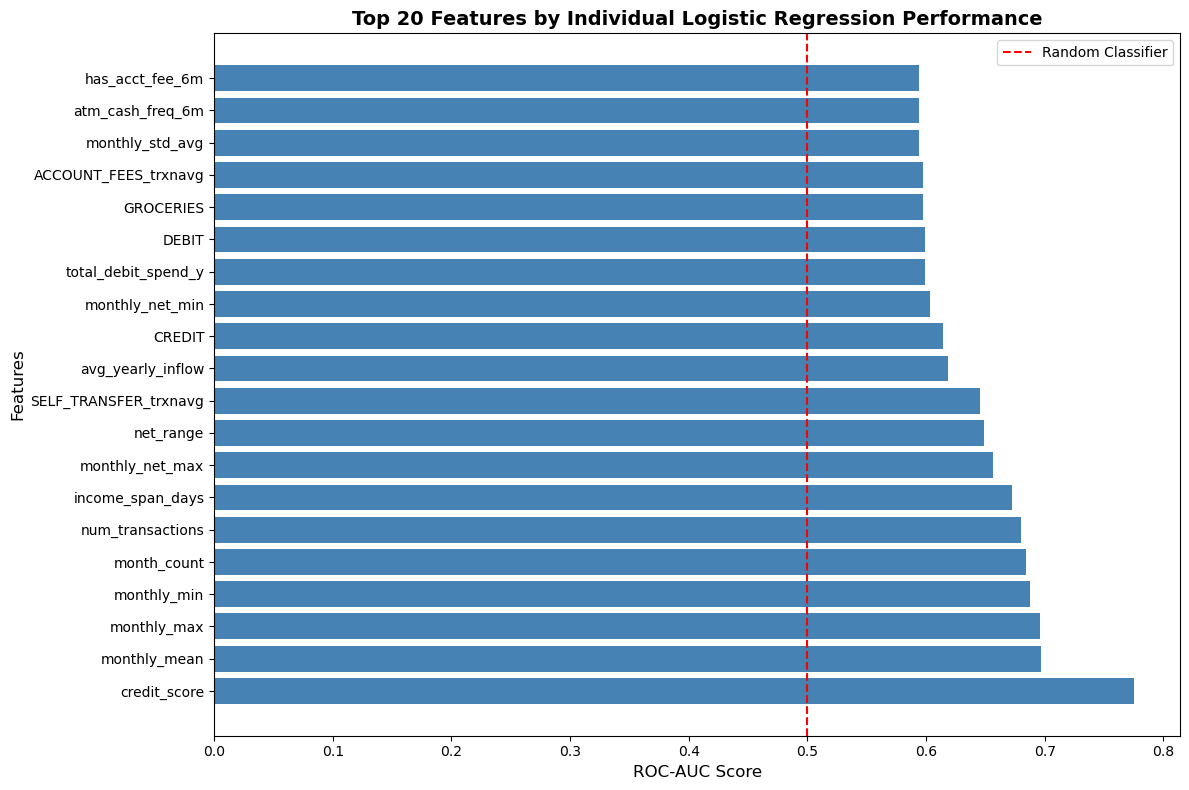

,Feature,AUC
0,credit_score,0.775190
1,monthly_mean,0.696773
2,monthly_max,0.695909
3,monthly_min,0.687439
4,month_count,0.683958
5,num_transactions,0.680339
6,income_span_days,0.672212
7,monthly_net_max,0.656028
8,net_range,0.649056
9,SELF_TRANSFER_trxnavg,0.645330


In [111]:
# ============================================================================
# INSERT AFTER CELL [102] - Feature Performance Analysis
# ============================================================================

# Cell [103]: Individual Feature Performance (AUC)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import pandas as pd

def plot_individual_feature_performance(X, y, top_n=20):
    """
    Plot AUC score for each feature individually
    """
    feature_aucs = {}
    
    for col in X.columns:
        # Handle missing values
        X_col = X[[col]].fillna(X[col].median())
        
        # Standardize
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_col)
        
        # Fit logistic regression
        lr = LogisticRegression(max_iter=1000, random_state=42)
        lr.fit(X_scaled, y)
        
        # Get predictions
        y_prob = lr.predict_proba(X_scaled)[:, 1]
        auc = roc_auc_score(y, y_prob)
        
        feature_aucs[col] = auc
    
    # Sort and plot top N features
    feature_aucs_sorted = dict(sorted(feature_aucs.items(), 
                                      key=lambda x: x[1], 
                                      reverse=True)[:top_n])
    
    plt.figure(figsize=(12, 8))
    plt.barh(list(feature_aucs_sorted.keys()), 
             list(feature_aucs_sorted.values()),
             color='steelblue')
    plt.xlabel('ROC-AUC Score', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.title(f'Top {top_n} Features by Individual Logistic Regression Performance', 
              fontsize=14, fontweight='bold')
    plt.axvline(x=0.5, color='red', linestyle='--', label='Random Classifier')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame(list(feature_aucs_sorted.items()), 
                       columns=['Feature', 'AUC']).sort_values('AUC', ascending=False)

# Run the analysis
feature_auc_df = plot_individual_feature_performance(X, y, top_n=20)
feature_auc_df

In [112]:
coefs = pipe.named_steps["model"].coef_[0]
coef_df = (pd.DataFrame({
    "feature": X_train_filled.columns,
    "coefficient": coefs,
    "abs_coefficient": np.abs(coefs)
}).sort_values("abs_coefficient", ascending=False))

coef_df


,feature,coefficient,abs_coefficient
7,monthly_max,1.325313,1.325313
6,monthly_mean,-1.076384,1.076384
103,avg_yearly_inflow,-1.001414,1.001414
114,total_debit_spend_x,0.963479,0.963479
121,debt_spend,0.890914,0.890914
...,...,...,...
37,HOME_IMPROVEMENT,0.004876,0.004876
115,atm_cash_spend,0.004279,0.004279
56,ATM_CASH_trxnavg,-0.003724,0.003724
60,BILLS_UTILITIES_trxnavg,-0.002447,0.002447


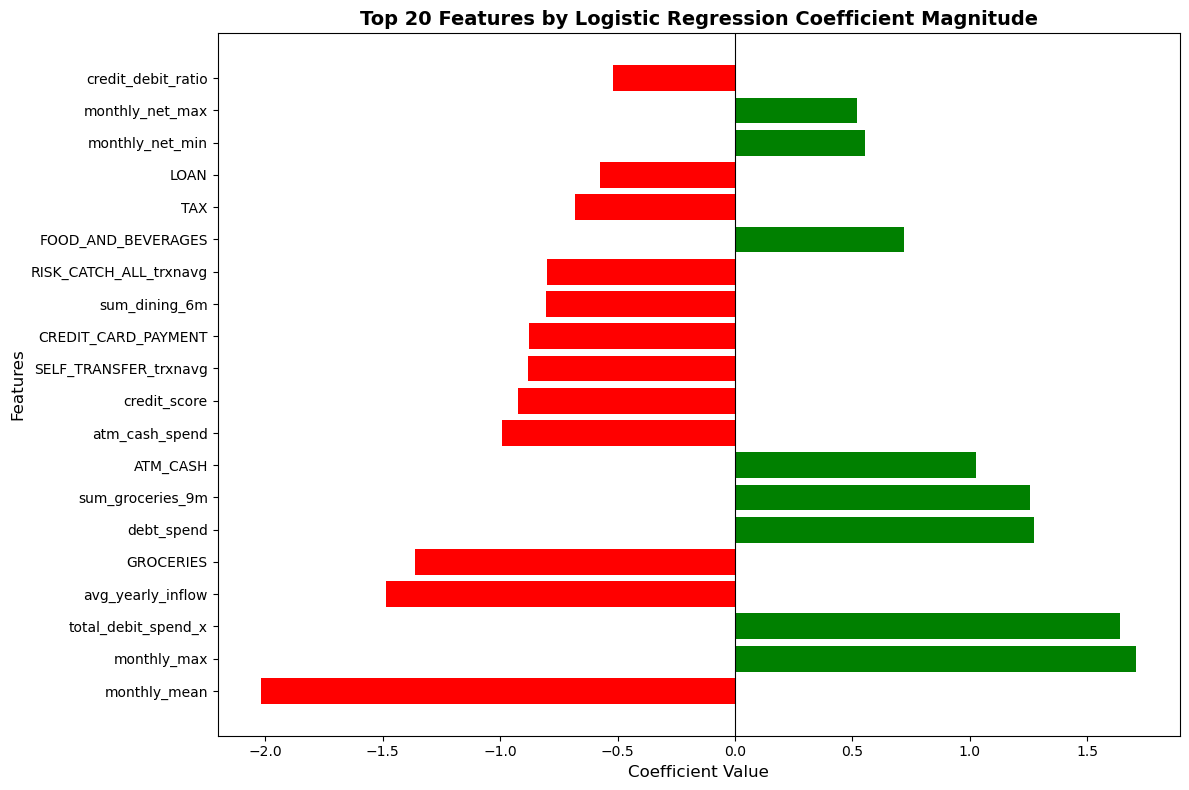

,feature,coefficient,abs_coefficient
6,monthly_mean,-2.017906,2.017906
7,monthly_max,1.709727,1.709727
114,total_debit_spend_x,1.641460,1.641460
103,avg_yearly_inflow,-1.487625,1.487625
24,GROCERIES,-1.363817,1.363817
121,debt_spend,1.273546,1.273546
107,sum_groceries_9m,1.257856,1.257856
39,ATM_CASH,1.028369,1.028369
115,atm_cash_spend,-0.991024,0.991024
102,credit_score,-0.925943,0.925943


In [113]:
# Cell [104]: Logistic Regression Coefficients
def plot_logistic_coefficients(X, y, top_n=20):
    """
    Plot logistic regression coefficients from full model
    """
    # Fill missing values
    X_filled = X.fillna(X.median())
    
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_filled)
    
    # Fit logistic regression
    lr = LogisticRegression(max_iter=3000, random_state=42, class_weight='balanced')
    lr.fit(X_scaled, y)
    
    # Get coefficients
    coef_df = pd.DataFrame({
        'feature': X.columns,
        'coefficient': lr.coef_[0],
        'abs_coefficient': np.abs(lr.coef_[0])
    }).sort_values('abs_coefficient', ascending=False).head(top_n)
    
    # Plot
    plt.figure(figsize=(12, 8))
    colors = ['red' if x < 0 else 'green' for x in coef_df['coefficient']]
    plt.barh(coef_df['feature'], coef_df['coefficient'], color=colors)
    plt.xlabel('Coefficient Value', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.title(f'Top {top_n} Features by Logistic Regression Coefficient Magnitude', 
              fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    plt.tight_layout()
    plt.show()
    
    return coef_df

coef_df = plot_logistic_coefficients(X, y, top_n=20)
coef_df

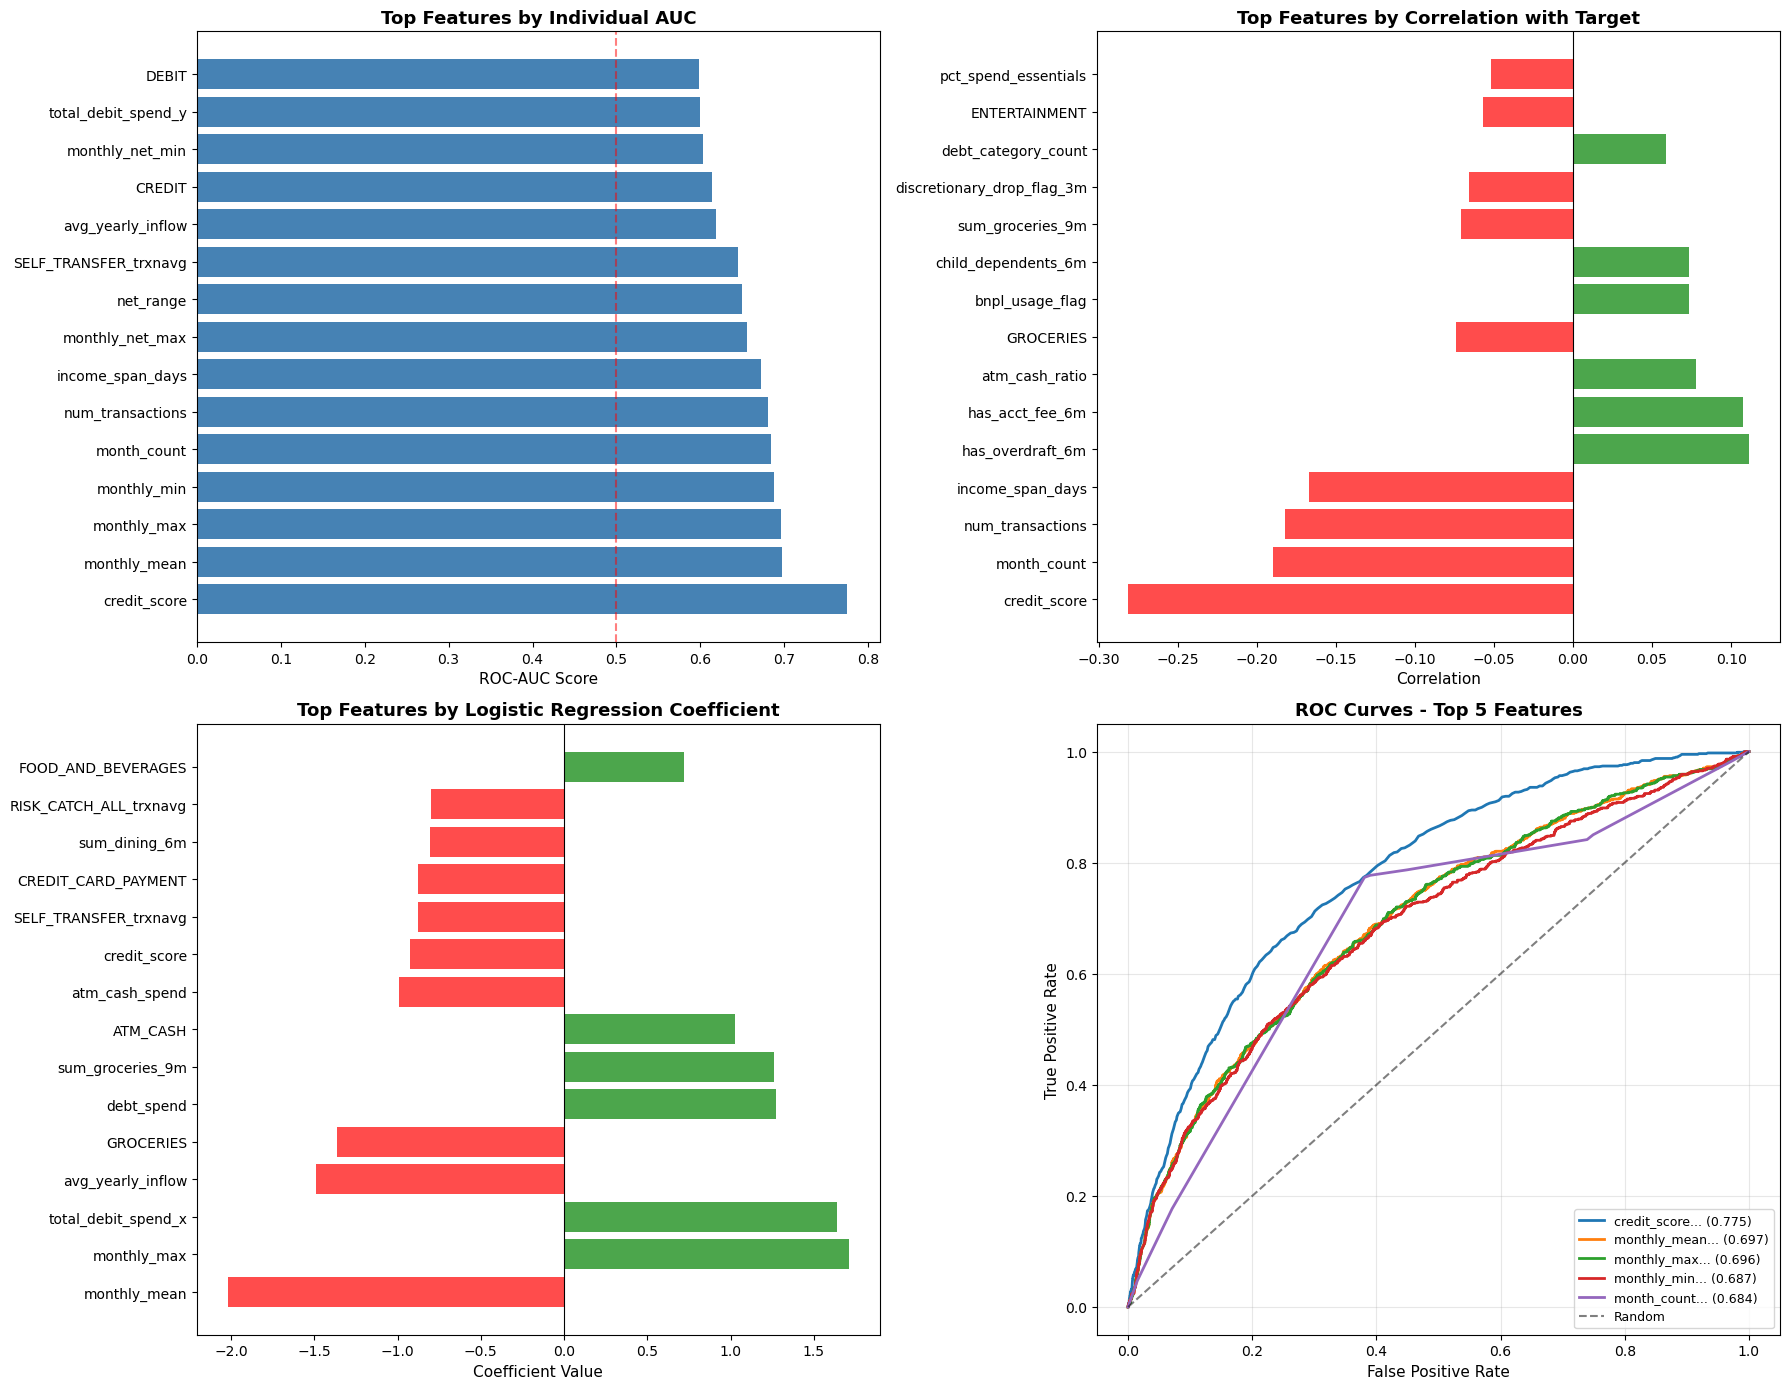

In [114]:
# Cell [106]: Comprehensive Feature Dashboard
def create_feature_performance_dashboard(X, y, top_n=15):
    """
    Create a comprehensive dashboard with multiple visualizations
    """
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # 1. Individual Feature AUCs (Top Left)
    feature_aucs = {}
    for col in X.columns:
        X_col = X[[col]].fillna(X[col].median())
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_col)
        lr = LogisticRegression(max_iter=1000, random_state=42)
        lr.fit(X_scaled, y)
        y_prob = lr.predict_proba(X_scaled)[:, 1]
        feature_aucs[col] = roc_auc_score(y, y_prob)
    
    top_aucs = dict(sorted(feature_aucs.items(), key=lambda x: x[1], reverse=True)[:top_n])
    axes[0, 0].barh(list(top_aucs.keys()), list(top_aucs.values()), color='steelblue')
    axes[0, 0].set_xlabel('ROC-AUC Score', fontsize=11)
    axes[0, 0].set_title('Top Features by Individual AUC', fontsize=13, fontweight='bold')
    axes[0, 0].axvline(x=0.5, color='red', linestyle='--', alpha=0.5)
    
    # 2. Correlations (Top Right)
    correlations = {col: np.corrcoef(X[col].fillna(X[col].median()), y)[0, 1] 
                   for col in X.columns}
    top_corrs = dict(sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)[:top_n])
    colors = ['red' if x < 0 else 'green' for x in top_corrs.values()]
    axes[0, 1].barh(list(top_corrs.keys()), list(top_corrs.values()), color=colors, alpha=0.7)
    axes[0, 1].set_xlabel('Correlation', fontsize=11)
    axes[0, 1].set_title('Top Features by Correlation with Target', fontsize=13, fontweight='bold')
    axes[0, 1].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    
    # 3. Full Model Coefficients (Bottom Left)
    X_filled = X.fillna(X.median())
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_filled)
    lr = LogisticRegression(max_iter=3000, random_state=42, class_weight='balanced')
    lr.fit(X_scaled, y)
    
    coef_dict = dict(zip(X.columns, lr.coef_[0]))
    top_coefs = dict(sorted(coef_dict.items(), key=lambda x: abs(x[1]), reverse=True)[:top_n])
    colors = ['red' if x < 0 else 'green' for x in top_coefs.values()]
    axes[1, 0].barh(list(top_coefs.keys()), list(top_coefs.values()), color=colors, alpha=0.7)
    axes[1, 0].set_xlabel('Coefficient Value', fontsize=11)
    axes[1, 0].set_title('Top Features by Logistic Regression Coefficient', fontsize=13, fontweight='bold')
    axes[1, 0].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    
    # 4. ROC Curves (Bottom Right)
    top_5_features = sorted(feature_aucs.items(), key=lambda x: x[1], reverse=True)[:5]
    for feat, auc in top_5_features:
        X_col = X[[feat]].fillna(X[feat].median())
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_col)
        lr = LogisticRegression(max_iter=1000, random_state=42)
        lr.fit(X_scaled, y)
        y_prob = lr.predict_proba(X_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y, y_prob)
        axes[1, 1].plot(fpr, tpr, label=f'{feat[:25]}... ({auc:.3f})', linewidth=2)
    
    axes[1, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
    axes[1, 1].set_xlabel('False Positive Rate', fontsize=11)
    axes[1, 1].set_ylabel('True Positive Rate', fontsize=11)
    axes[1, 1].set_title('ROC Curves - Top 5 Features', fontsize=13, fontweight='bold')
    axes[1, 1].legend(loc='lower right', fontsize=9)
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

create_feature_performance_dashboard(X, y, top_n=15)

In [104]:
for col in df_eval:
    print(col)

prism_consumer_id
monthly_net_total
monthly_net_avg
monthly_net_max
monthly_net_min
monthly_std_avg
net_range
monthly_mean
monthly_max
monthly_min
trxndf_count
month_count
DQ_TARGET
CREDIT
DEBIT
credit_debit_ratio
refund_ratio_x
paycheck_ratio
OVERDRAFT
ACCOUNT_FEES
CREDIT_CARD_PAYMENT
RTO_LTO
INSURANCE
AUTOMOTIVE
BNPL
INVESTMENT
GROCERIES
ENTERTAINMENT
HEALTHCARE_MEDICAL
GENERAL_MERCHANDISE
MISCELLANEOUS
TRAVEL
FOOD_AND_BEVERAGES
ESSENTIAL_SERVICES
EDUCATION
LOAN
CHILD_DEPENDENTS
DEBT
EXTERNAL_TRANSFER
HOME_IMPROVEMENT
GAMBLING
ATM_CASH
SELF_TRANSFER
PETS
MORTGAGE
BILLS_UTILITIES
AUTO_LOAN
RENT
GOVERNMENT_SERVICES
TAX
TRANSPORATION
FITNESS
BANKING_CATCH_ALL
LEGAL
GIFTS_DONATIONS
RISK_CATCH_ALL
income_span_days
ACCOUNT_FEES_trxnavg
ATM_CASH_trxnavg
AUTOMOTIVE_trxnavg
AUTO_LOAN_trxnavg
BANKING_CATCH_ALL_trxnavg
BILLS_UTILITIES_trxnavg
BNPL_trxnavg
CHILD_DEPENDENTS_trxnavg
CORPORATE_PAYMENTS_trxnavg
CREDIT_CARD_PAYMENT_trxnavg
DEBT_trxnavg
DEPOSIT_trxnavg
EDUCATION_trxnavg
ENTERTAINMENT_

In [105]:
from sklearn.feature_selection import RFE

rfe = RFE(
    estimator=xgb_model,
    n_features_to_select=50,
    step=5  # faster than step=1
)

rfe.fit(X_train, y_train)

selected_50 = X_train.columns[rfe.support_].tolist()
ranking = pd.Series(rfe.ranking_, index=X_train.columns).sort_values()

print("Selected 50:", selected_50[:10], "...")
print("Top ranked:\n", ranking.head(20))


Selected 50: ['monthly_net_total', 'monthly_net_max', 'net_range', 'monthly_mean', 'monthly_max', 'monthly_min', 'month_count', 'refund_ratio_x', 'paycheck_ratio', 'OVERDRAFT'] ...
Top ranked:
 GAMBLING_trxnavg               1
LOAN                           1
monthly_net_max                1
BANKING_CATCH_ALL              1
atm_cash_spend                 1
ACCOUNT_FEES_trxnavg           1
AUTOMOTIVE_trxnavg             1
AUTO_LOAN_trxnavg              1
BNPL_trxnavg                   1
has_overdraft_6m               1
pct_spend_utilities            1
CREDIT_CARD_PAYMENT_trxnavg    1
DEBT_trxnavg                   1
ENTERTAINMENT_trxnavg          1
FITNESS_trxnavg                1
FOOD_AND_BEVERAGES_trxnavg     1
monthly_min                    1
pct_spend_essentials           1
pct_spend_gambling             1
GROCERIES_trxnavg              1
dtype: int64


In [106]:
X_train_50 = X_train[selected_50]
X_test_50  = X_test[selected_50]

xgb_model.fit(X_train_50, y_train)
y_test_prob = xgb_model.predict_proba(X_test_50)[:, 1]

print("AUC (top 50):", roc_auc_score(y_test, y_test_prob))


AUC (top 50): 0.8108343720322887


### Random Forest

In [107]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_prob))


ROC AUC: 0.8098253501899334


In [108]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=600,          # more trees
    max_depth=6,               # slightly deeper interactions
    learning_rate=0.03,        # slower learning → better generalization
    subsample=0.85,
    colsample_bytree=0.85,
    min_child_weight=3,        # reduce noisy splits
    gamma=0.1,                 # require meaningful gain
    reg_alpha=0.1,             # L1 regularization
    reg_lambda=1.0,            # L2 regularization
    eval_metric="auc",
    tree_method="hist",
    random_state=42
)


xgb.fit(X_train, y_train)
from sklearn.metrics import roc_auc_score, classification_report

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

ROC AUC: 0.8191958986229819
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95      1664
         1.0       0.39      0.08      0.13       162

    accuracy                           0.91      1826
   macro avg       0.66      0.53      0.54      1826
weighted avg       0.87      0.91      0.88      1826



In [109]:
import pandas as pd

importance = pd.Series(
    xgb.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importance

month_count                   0.051359
credit_score                  0.041306
num_transactions              0.023514
monthly_min                   0.016816
debt_category_count           0.014980
                                ...   
bnpl_usage_flag               0.000000
RISK_CATCH_ALL_trxnavg        0.000000
CORPORATE_PAYMENTS_trxnavg    0.000000
CHILD_DEPENDENTS_trxnavg      0.000000
RISK_CATCH_ALL                0.000000
Length: 129, dtype: float32

### XGBoost

In [110]:
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

# X = dataframe of features
# y = target column (0/1)

# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- XGBoost Model ---
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
    random_state=42
)

# --- RFE ---
rfe = RFE(
    estimator=xgb_model,
    n_features_to_select=50,
    step=1   # speed up elimination
)

rfe.fit(X_train, y_train)

# Selected feature names
selected_features = X.columns[rfe.support_]
print("Selected Features:", list(selected_features))

# Transform datasets
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# --- Train final model on reduced features ---
xgb_model.fit(X_train_rfe, y_train)

# --- Predict probabilities ---
y_probs = xgb_model.predict_proba(X_test_rfe)[:, 1]

# --- AUC ---
auc_score = roc_auc_score(y_test, y_probs)
print("Test ROC-AUC:", auc_score)


KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd

# X = dataframe of features
# y = target column (0/1)

# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Random Forest Model ---
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,        # use all cores
    random_state=42
)

# --- RFE ---
rfe = RFE(
    estimator=rf_model,
    n_features_to_select=50,
    step=5   # step=1 = slow but precise, step=5 faster
)

rfe.fit(X_train, y_train)

# Selected feature names
selected_features = X.columns[rfe.support_]
print("Selected Features:", list(selected_features))

# Transform datasets
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# --- Train final model on reduced features ---
rf_model.fit(X_train_rfe, y_train)

# --- Predict probabilities ---
y_probs = rf_model.predict_proba(X_test_rfe)[:, 1]

# --- AUC ---
auc_score = roc_auc_score(y_test, y_probs)
print("Test ROC-AUC:", auc_score)


In [ ]:
rf_full = RandomForestClassifier(
    n_estimators=300,
    n_jobs=-1,
    random_state=42
)

rf_full.fit(X_train, y_train)
full_probs = rf_full.predict_proba(X_test)[:, 1]
full_auc = roc_auc_score(y_test, full_probs)

print("Full Feature AUC:", full_auc)
print("RFE Feature AUC:", auc_score)


In [ ]:
X = X.drop(columns='credit_score')

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np

# X = dataframe of features
# y = target column (0/1)

# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Forward Selection ---
selected_features = []
remaining_features = list(X.columns)
target_feature_count = 50

for i in range(target_feature_count):
    best_auc = 0
    best_feat = None
    
    for feat in remaining_features:
        current_feats = selected_features + [feat]
        model = RandomForestClassifier(
            n_estimators=200,
            n_jobs=-1,
            random_state=42
        )
        model.fit(X_train[current_feats], y_train)
        y_probs = model.predict_proba(X_test[current_feats])[:, 1]
        auc = roc_auc_score(y_test, y_probs)
        
        if auc > best_auc:
            best_auc = auc
            best_feat = feat
    
    if best_feat is None:
        print("No improvement; stopping early.")
        break
    
    selected_features.append(best_feat)
    remaining_features.remove(best_feat)
    print(f"Step {i+1}: Added feature '{best_feat}' with AUC={best_auc:.4f}")

# --- Final Selected Features ---
print("Top 50 Selected Features:", selected_features)

# --- Train Final Model ---
final_model = RandomForestClassifier(
    n_estimators=300,
    n_jobs=-1,
    random_state=42
)
final_model.fit(X_train[selected_features], y_train)

y_probs = final_model.predict_proba(X_test[selected_features])[:, 1]
final_auc = roc_auc_score(y_test, y_probs)
print("Final Test ROC-AUC:", final_auc)

In [ ]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# X = dataframe of features
# y = target column (0/1)

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Forward Selection ---
selected_features = []
remaining_features = list(X.columns)
target_feature_count = 50

for i in range(target_feature_count):
    best_auc = 0
    best_feat = None
    
    for feat in remaining_features:
        current_feats = selected_features + [feat]
        
        model = XGBClassifier(
            n_estimators=200,
            max_depth=5,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="auc",
            random_state=42
        )
        model.fit(X_train[current_feats], y_train)
        
        y_probs = model.predict_proba(X_test[current_feats])[:, 1]
        auc = roc_auc_score(y_test, y_probs)
        
        if auc > best_auc:
            best_auc = auc
            best_feat = feat
    
    if best_feat is None:
        print("No improvement; stopping early.")
        break
    
    selected_features.append(best_feat)
    remaining_features.remove(best_feat)
    print(f"Step {i+1}: Added feature '{best_feat}' with AUC={best_auc:.4f}")

# --- Final Selected Features ---
print("Top 50 Selected Features:", selected_features)

# --- Train Final XGBoost Model ---
final_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
    use_label_encoder=False,
    random_state=42
)
final_model.fit(X_train[selected_features], y_train)

y_probs = final_model.predict_proba(X_test[selected_features])[:, 1]
final_auc = roc_auc_score(y_test, y_probs)
print("Final Test ROC-AUC:", final_auc)
